# **Predicting gas emission using machine learning** 
 


In [ ]:
!pip install pycountry_convert
!pip install scikit_optimize
!pip install pandas-profiling
!pip install pydot
!pip install pyqt5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 26.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.5/227.5 kB 21.4 MB/s eta 0:00:00
  Created wheel for pycountry: filename=pycountry-22.3.5-py2.py3-none-any.whl size=10681847 sha256=7a83b34365b4c470040169e627c2f1d89fa502e50c2e557fc0445ed870325d9a
  Stored in directory: /root/.cache/pip/wheels/47/15/92/e6dc85fcb0686c82e1edbcfdf80cfe4808c058813fed0baa8f
Successfully built pycountry
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 4.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 68.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.3/358.3 kB 34.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.9/59.9 MB 13.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import numpy as np
from pandas_profiling import ProfileReport
import seaborn
import pycountry_convert as pc
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import SelectKBest, mutual_info_regression, f_regression
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import cross_validate, GridSearchCV,train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neural_network import MLPRegressor
from statsmodels.regression.linear_model import OLS
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import export_graphviz
import pydot
from statsmodels.api import add_constant
import itertools
from IPython.display import Image
from skopt import BayesSearchCV
from catboost import CatBoostRegressor
from tempfile import mkdtemp
from joblib import Memory
cachedir = mkdtemp()
#memory = Memory(cachedir=cachedir, verbose=5)
%matplotlib inline
#import lightgbm as lgb
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, StackingRegressor
from matplotlib.colors import Normalize
from sklearn.ensemble import BaggingRegressor

In [ ]:
import sys
runningOnColab = 'google.colab' in sys.modules
if runningOnColab:
  from google.colab import drive
  drive.mount('/content/drive')
  %cd '/content/drive/MyDrive/ece9039'

Mounted at /content/drive
/content/drive/MyDrive/ece9039


# Read Datasets

In [ ]:
def readEmissionCSV(year):
    fileName = 'gt_' + str(year) + '.csv'
    gt_yr_data = pd.read_csv(fileName)
    gt_yr_data['year'] = year
    return gt_yr_data

In [ ]:
gt2011 = pd.read_csv("/content/drive/MyDrive/ece9039/gt_2011.csv")
gt2012 = pd.read_csv("/content/drive/MyDrive/ece9039/gt_2012.csv")
gt2013 = pd.read_csv("/content/drive/MyDrive/ece9039/gt_2013.csv")
gt2014 = pd.read_csv("/content/drive/MyDrive/ece9039/gt_2014.csv")
gt2015 = pd.read_csv("/content/drive/MyDrive/ece9039/gt_2015.csv")
gt2011["year"] = [2011] * len(gt2011)
gt2012["year"] = [2012] * len(gt2012)
gt2013["year"] = [2013] * len(gt2013)
gt2014["year"] = [2014] * len(gt2014)
gt2015["year"] = [2015] * len(gt2015)
gt_data = pd.concat([gt2011, gt2012, gt2013, gt2014, gt2015])
#@markdown - Drop CO
#gt_data = gt_data.drop('CO',axis = 1)
gt_data

AT      AP      AH    AFDP    GTEP     TIT     TAT     TEY     CDP  \
0     4.5878  1018.7  83.675  3.5758  23.979  1086.2  549.83  134.67  11.898   
1     4.2932  1018.3  84.235  3.5709  23.951  1086.1  550.05  134.67  11.892   
2     3.9045  1018.4  84.858  3.5828  23.990  1086.5  550.19  135.10  12.042   
3     3.7436  1018.3  85.434  3.5808  23.911  1086.5  550.17  135.03  11.990   
4     3.7516  1017.8  85.182  3.5781  23.917  1085.9  550.00  134.67  11.910   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
7379  3.6268  1028.5  93.200  3.1661  19.087  1037.0  541.59  109.08  10.411   
7380  4.1674  1028.6  94.036  3.1923  19.016  1037.6  542.28  108.79  10.344   
7381  5.4820  1028.5  95.219  3.3128  18.857  1038.0  543.48  107.81  10.462   
7382  5.8837  1028.7  94.200  3.9831  23.563  1076.9  550.11  131.41  11.771   
7383  6.0392  1028.8  94.547  3.8752  22.524  1067.9  548.23  125.41  11.462   

            CO      NOX  year  
0      0.32663   81.952  2011  
1      0.44784   82.377  2011  
2      0.45144   83.776  2011  
3      0.23107   82.505  2011  
4      0.26747   82.028  2011  
...        ...      ...   ...  
7379  10.99300   89.172  2015  
7380  11.14400   88.849  2015  
7381  11.41400   96.147  2015  
7382   3.31340   64.738  2015  
7383  11.98100  109.240  2015  

[36733 rows x 12 columns]

<Axes: >

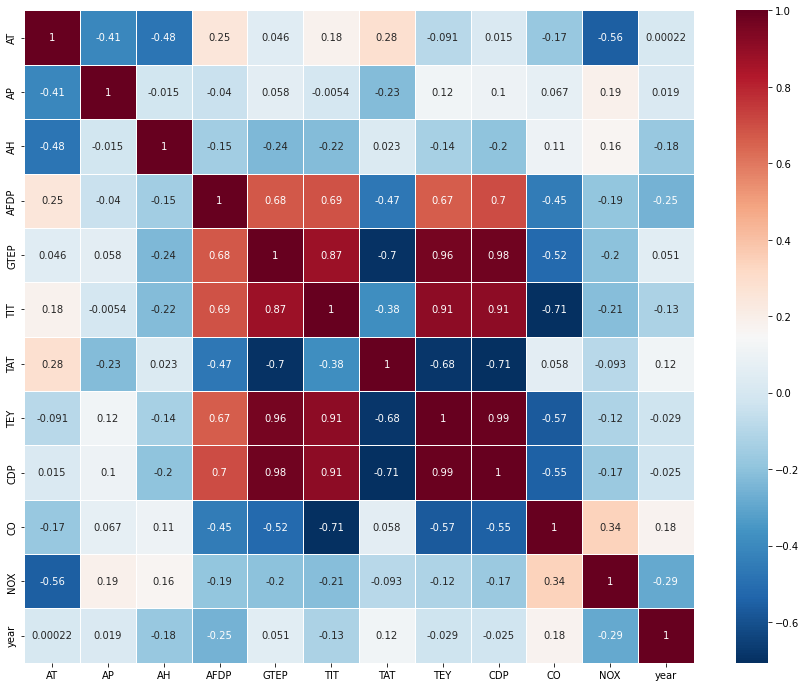

In [ ]:
corr = gt_data.corr()
plt.figure(figsize=(15, 12))
seaborn.heatmap(corr, linewidths=0.5,cmap="RdBu_r",annot=True)

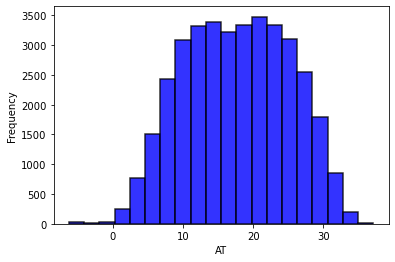

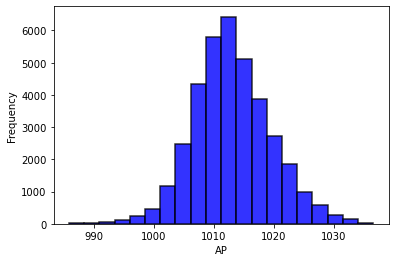

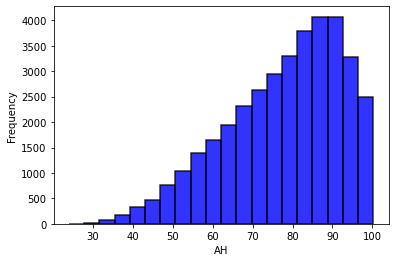

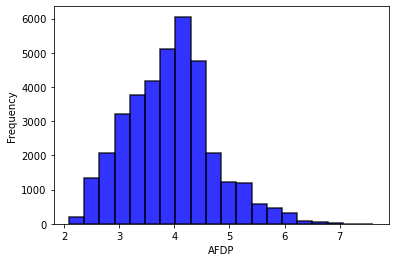

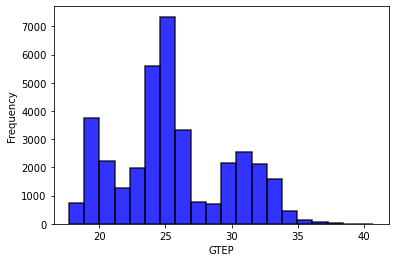

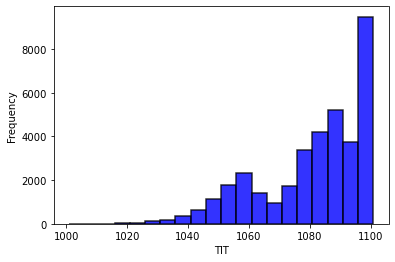

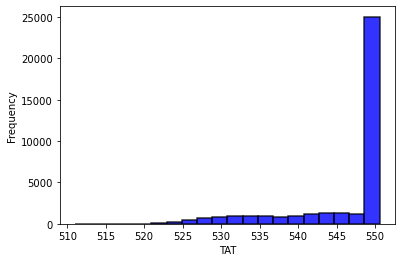

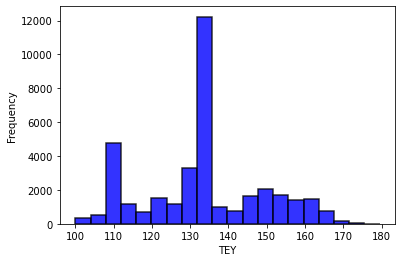

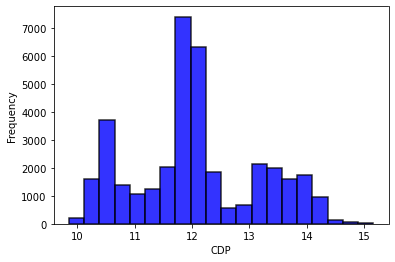

In [ ]:
numerical_features = ['AT', 'AP', 'AH', 'AFDP', 'GTEP', 'TIT', 'TAT', 'TEY', 'CDP'] 
for i in numerical_features:
    plt.hist(gt_data[i], bins=20, edgecolor='k', facecolor='b', linewidth=1.5, alpha=0.8)
    plt.xlabel(i)
    plt.ylabel('Frequency')
    plt.show()

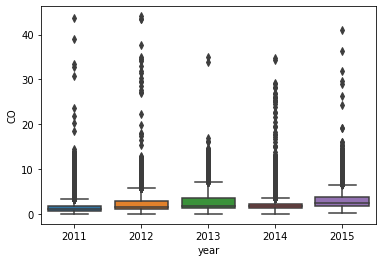

In [ ]:
cat_list = ['year']
target = 'CO'
for item in cat_list:
    seaborn.boxplot(x = gt_data[item],y = gt_data[target], order=list(set(gt_data[item])))
    plt.show()

AT


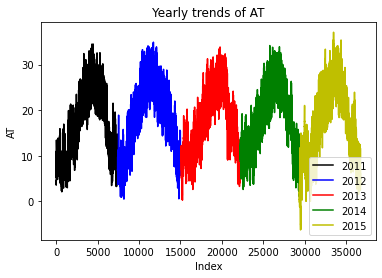

AP


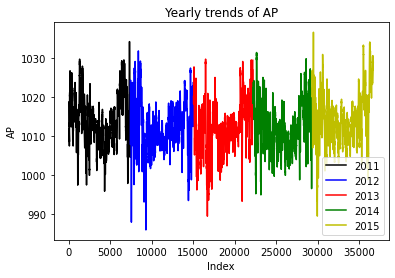

AH


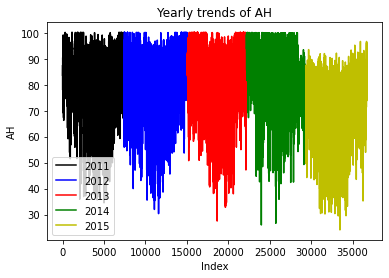

AFDP


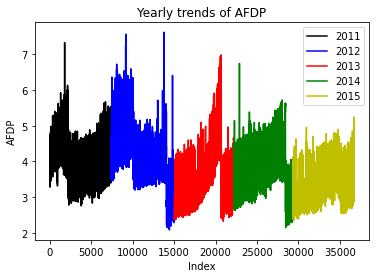

GTEP


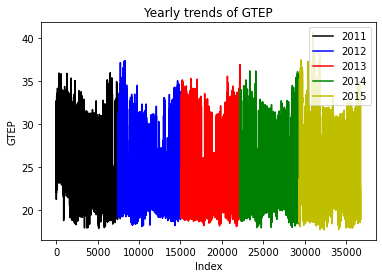

TIT


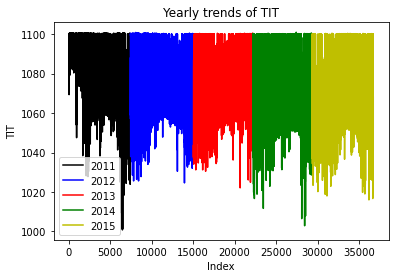

TAT


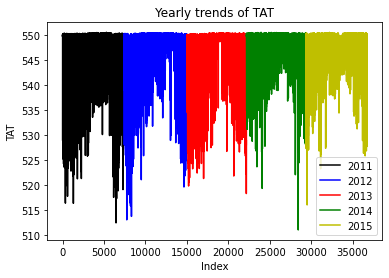

TEY


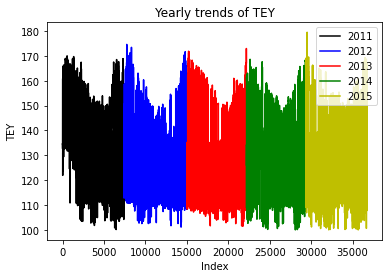

CDP


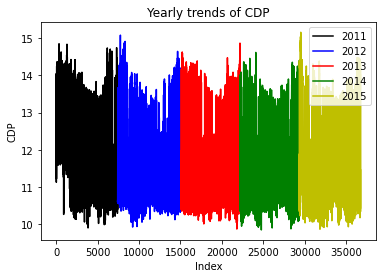

In [ ]:
years = list(gt_data['year'].unique())
start_yr = 2011
features = ['AT', 'AP', 'AH', 'AFDP', 'GTEP', 'TIT', 'TAT', 'TEY', 'CDP']
C = ['k','b','r','g','y']
gt_data.reset_index(drop=True, inplace = True)

for feat in features:
    print(feat)
    for index, yr in enumerate(years):
        df = gt_data[gt_data['year'] == yr]
        plt.plot(df.index, df[feat], color = C[index], label = str(start_yr + index))
    plt.xlabel('Index')
    plt.ylabel(feat)
    plt.title('Yearly trends of ' + feat)
    plt.legend()
    plt.show()

AT


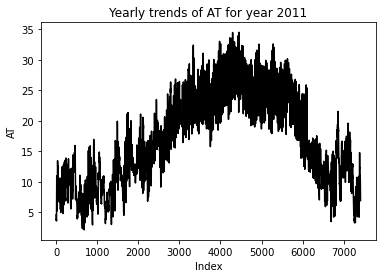

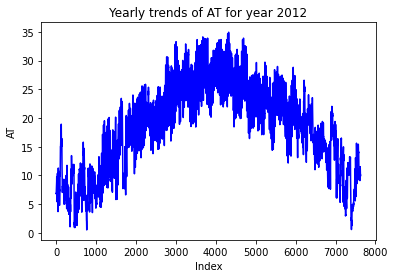

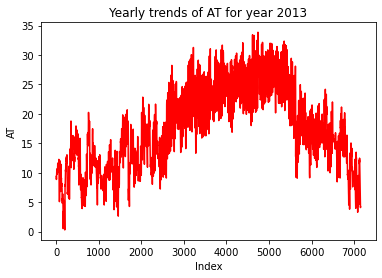

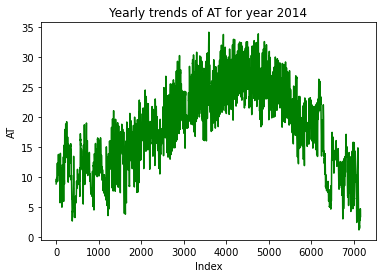

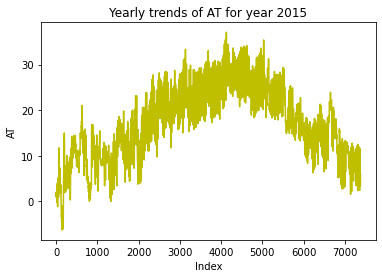

AP


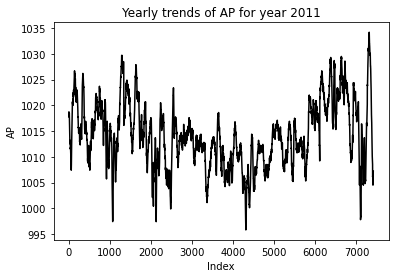

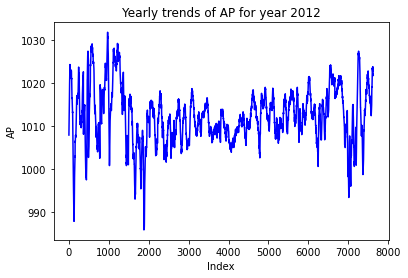

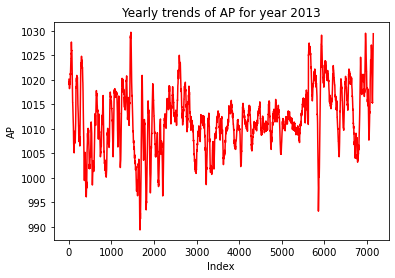

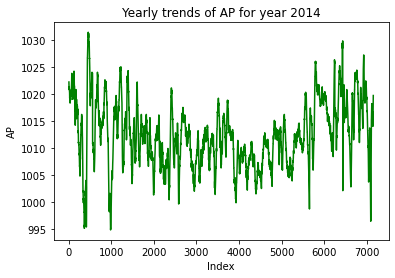

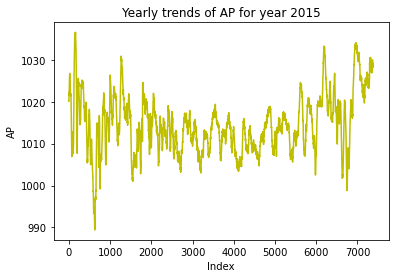

AH


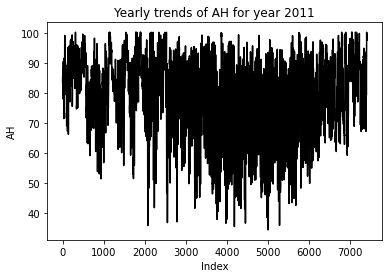

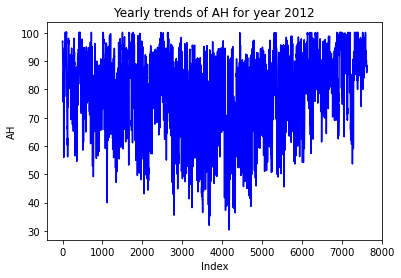

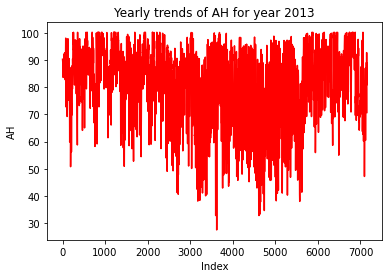

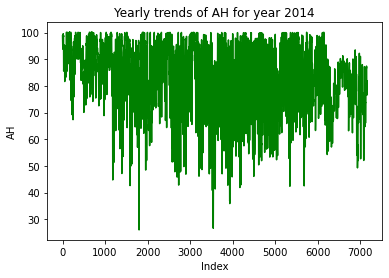

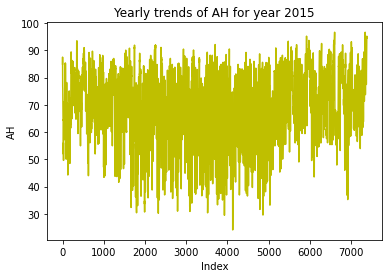

AFDP


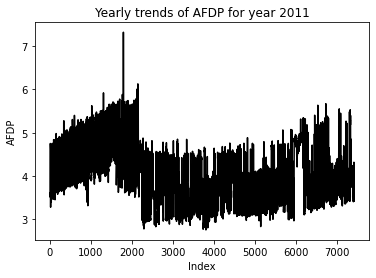

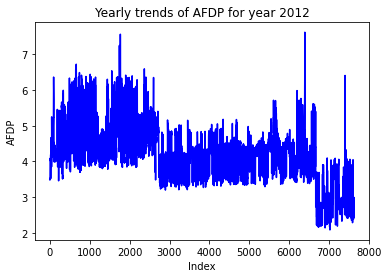

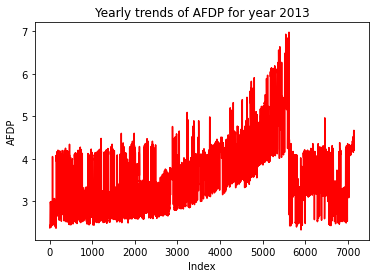

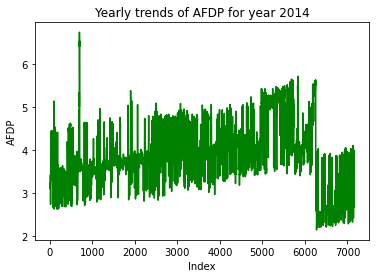

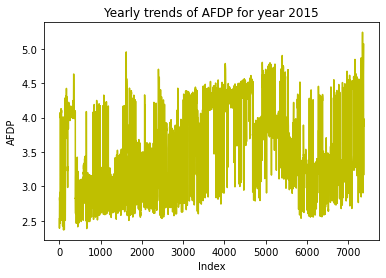

GTEP


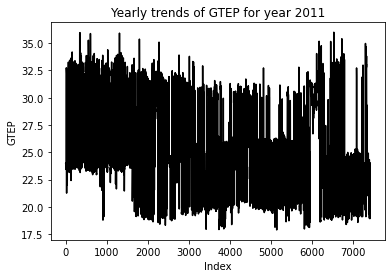

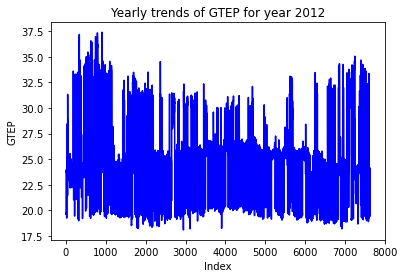

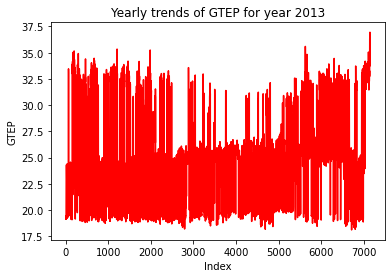

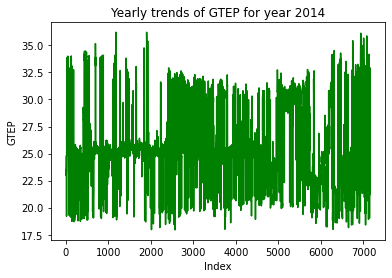

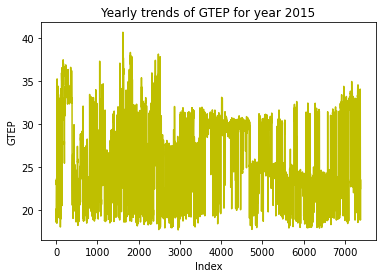

TIT


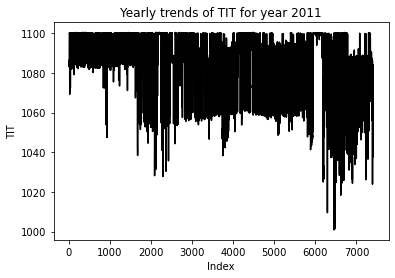

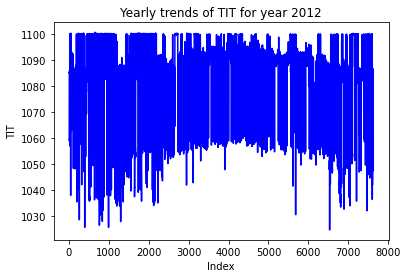

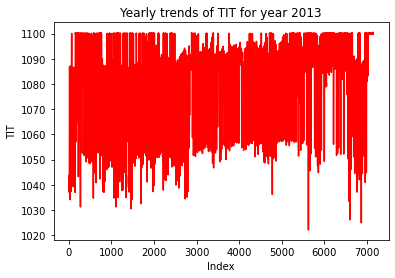

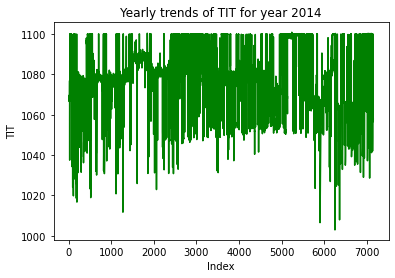

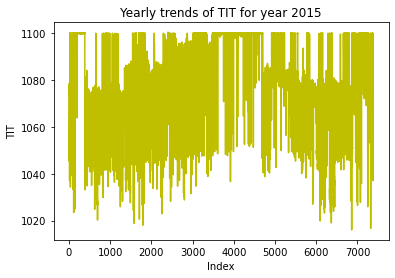

TAT


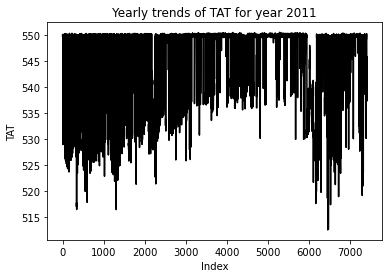

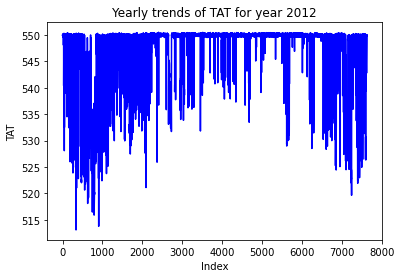

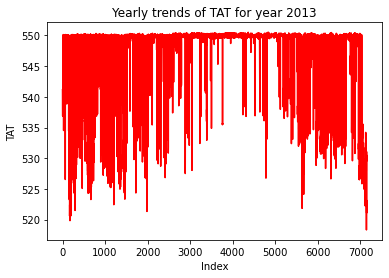

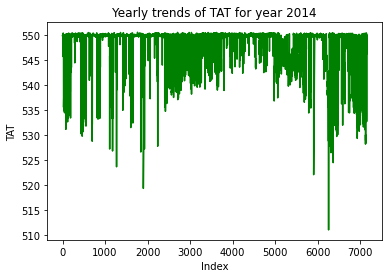

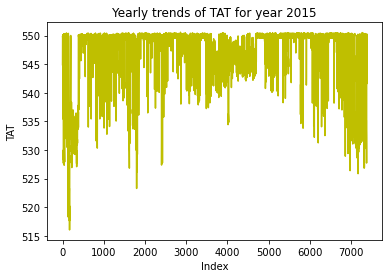

TEY


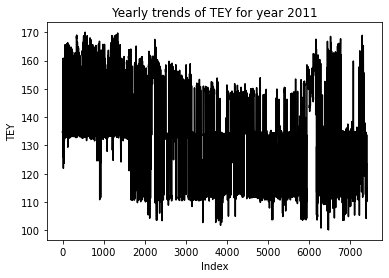

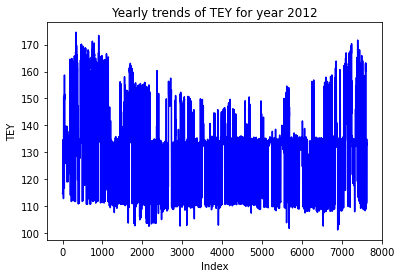

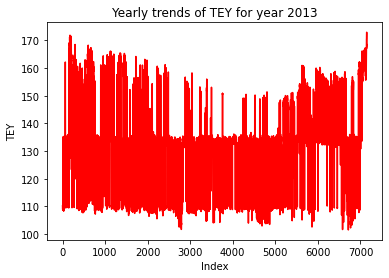

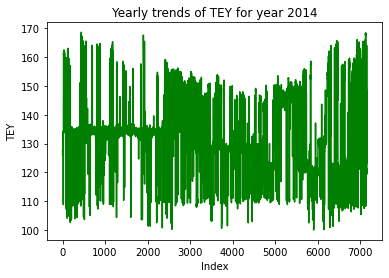

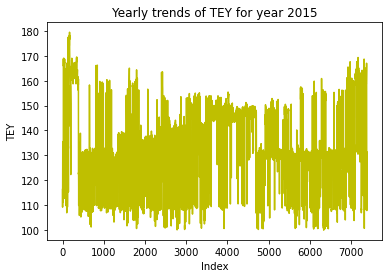

CDP


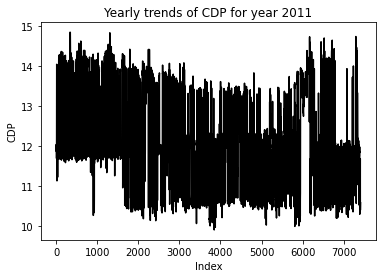

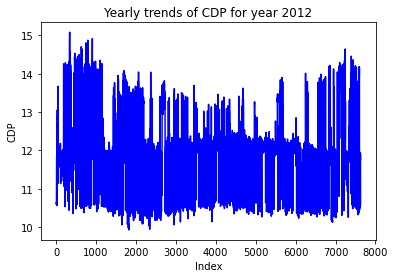

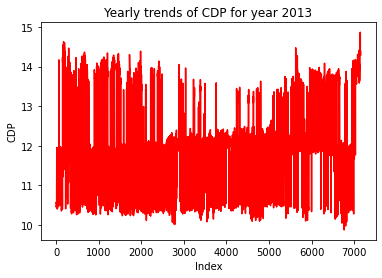

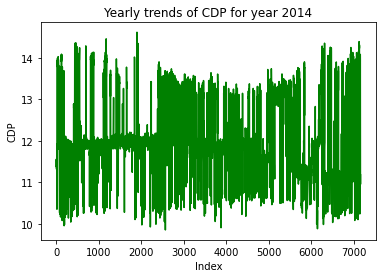

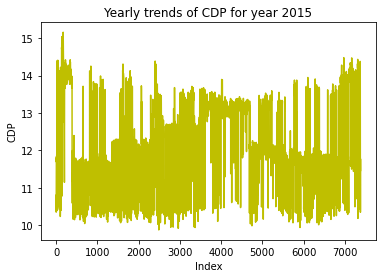

In [ ]:
years = list(gt_data['year'].unique())
start_yr = 2011
features = ['AT', 'AP', 'AH', 'AFDP', 'GTEP', 'TIT', 'TAT', 'TEY', 'CDP']
C = ['k','b','r','g','y']

for feat in features:
    print(feat)
    for index, yr in enumerate(years):
        df = gt_data[gt_data['year'] == yr]
        x_axis = np.arange(len(df.index))
        plt.plot(x_axis, df[feat], color = C[index], label = str(start_yr + index))
        plt.xlabel('Index')
        plt.ylabel(feat)
        plt.title('Yearly trends of ' + feat + ' for year ' + str(start_yr + index))
        plt.show()

Handle Categorical Features

In [ ]:
gt_data_cat = gt_data.copy()
dum = pd.get_dummies(gt_data_cat['year'], columns=['year'], drop_first=False, prefix = 'year')
gt_data_cat = pd.concat([gt_data_cat, dum], axis=1)
print(gt_data_cat.head())
gt_data_cat.describe()

       AT      AP      AH    AFDP    GTEP     TIT     TAT     TEY     CDP  \
0  4.5878  1018.7  83.675  3.5758  23.979  1086.2  549.83  134.67  11.898   
1  4.2932  1018.3  84.235  3.5709  23.951  1086.1  550.05  134.67  11.892   
2  3.9045  1018.4  84.858  3.5828  23.990  1086.5  550.19  135.10  12.042   
3  3.7436  1018.3  85.434  3.5808  23.911  1086.5  550.17  135.03  11.990   
4  3.7516  1017.8  85.182  3.5781  23.917  1085.9  550.00  134.67  11.910   

        CO     NOX  year  year_2011  year_2012  year_2013  year_2014  \
0  0.32663  81.952  2011          1          0          0          0   
1  0.44784  82.377  2011          1          0          0          0   
2  0.45144  83.776  2011          1          0          0          0   
3  0.23107  82.505  2011          1          0          0          0   
4  0.26747  82.028  2011          1          0          0          0   

   year_2015  
0          0  
1          0  
2          0  
3          0  
4          0  


AT            AP            AH          AFDP          GTEP  \
count  36733.000000  36733.000000  36733.000000  36733.000000  36733.000000   
mean      17.712726   1013.070165     77.867015      3.925518     25.563801   
std        7.447451      6.463346     14.461355      0.773936      4.195957   
min       -6.234800    985.850000     24.085000      2.087400     17.698000   
25%       11.781000   1008.800000     68.188000      3.355600     23.129000   
50%       17.801000   1012.600000     80.470000      3.937700     25.104000   
75%       23.665000   1017.000000     89.376000      4.376900     29.061000   
max       37.103000   1036.600000    100.200000      7.610600     40.716000   

                TIT           TAT           TEY           CDP            CO  \
count  36733.000000  36733.000000  36733.000000  36733.000000  36733.000000   
mean    1081.428084    546.158517    133.506404     12.060525      2.372468   
std       17.536373      6.842360     15.618634      1.088795      2.262672   
min     1000.800000    511.040000    100.020000      9.851800      0.000388   
25%     1071.800000    544.720000    124.450000     11.435000      1.182400   
50%     1085.900000    549.880000    133.730000     11.965000      1.713500   
75%     1097.000000    550.040000    144.080000     12.855000      2.842900   
max     1100.900000    550.610000    179.500000     15.159000     44.103000   

                NOX          year     year_2011     year_2012     year_2013  \
count  36733.000000  36733.000000  36733.000000  36733.000000  36733.000000   
mean      65.293067   2012.985735      0.201753      0.207661      0.194702   
std       11.678357      1.418965      0.401314      0.405638      0.395977   
min       25.905000   2011.000000      0.000000      0.000000      0.000000   
25%       57.162000   2012.000000      0.000000      0.000000      0.000000   
50%       63.849000   2013.000000      0.000000      0.000000      0.000000   
75%       71.548000   2014.000000      0.000000      0.000000      0.000000   
max      119.910000   2015.000000      1.000000      1.000000      1.000000   

          year_2014     year_2015  
count  36733.000000  36733.000000  
mean       0.194866      0.201018  
std        0.396103      0.400767  
min        0.000000      0.000000  
25%        0.000000      0.000000  
50%        0.000000      0.000000  
75%        0.000000      0.000000  
max        1.000000      1.000000

Standardization

In [ ]:


scalar = StandardScaler()
gt_data_S = scalar.fit_transform(gt_data_cat)
gt_data_S_df = pd.DataFrame(gt_data_S, columns = gt_data_cat.columns)
print('gt_data_S_df')
print(gt_data_S_df.describe())

gt_data_S_df
                 AT            AP            AH          AFDP          GTEP  \
count  3.673300e+04  3.673300e+04  3.673300e+04  3.673300e+04  3.673300e+04   
mean  -1.176081e-16 -1.233647e-14 -5.570912e-16 -1.015144e-15  5.292366e-16   
std    1.000014e+00  1.000014e+00  1.000014e+00  1.000014e+00  1.000014e+00   
min   -3.215577e+00 -4.211524e+00 -3.719067e+00 -2.375059e+00 -1.874640e+00   
25%   -7.964882e-01 -6.606830e-01 -6.693112e-01 -7.363991e-01 -5.802810e-01   
50%    1.185304e-02 -7.274427e-02  1.799983e-01  1.574091e-02 -1.095835e-01   
75%    7.992472e-01  6.080269e-01  7.958550e-01  5.832377e-01  8.334799e-01   
max    2.603647e+00  3.640553e+00  1.544343e+00  4.761549e+00  3.611191e+00   

                TIT           TAT           TEY           CDP            CO  \
count  3.673300e+04  3.673300e+04  3.673300e+04  3.673300e+04  3.673300e+04   
mean   9.609823e-15 -8.300659e-15  9.888369e-16 -4.704326e-16 -7.427883e-17   
std    1.000014e+00  1.000014e+00  1.0

Extract Features and Target Variables

In [ ]:
X_gt = gt_data_cat[['AT', 'AP', 'AH', 'AFDP', 'GTEP', 'TIT', 'TAT', 'TEY', 'CDP', 'year_2011', 'year_2012', 'year_2013', 'year_2014', 'year_2015']]
Y_gt_df = gt_data_cat[['CO']]
Y_gt = gt_data_cat.CO

print('X_gt')
print(X_gt.head())
print(X_gt.describe())

print('Y_gt')
print(Y_gt_df.head())
print(Y_gt_df.describe())

X_gt
       AT      AP      AH    AFDP    GTEP     TIT     TAT     TEY     CDP  \
0  4.5878  1018.7  83.675  3.5758  23.979  1086.2  549.83  134.67  11.898   
1  4.2932  1018.3  84.235  3.5709  23.951  1086.1  550.05  134.67  11.892   
2  3.9045  1018.4  84.858  3.5828  23.990  1086.5  550.19  135.10  12.042   
3  3.7436  1018.3  85.434  3.5808  23.911  1086.5  550.17  135.03  11.990   
4  3.7516  1017.8  85.182  3.5781  23.917  1085.9  550.00  134.67  11.910   

   year_2011  year_2012  year_2013  year_2014  year_2015  
0          1          0          0          0          0  
1          1          0          0          0          0  
2          1          0          0          0          0  
3          1          0          0          0          0  
4          1          0          0          0          0  
                 AT            AP            AH          AFDP          GTEP  \
count  36733.000000  36733.000000  36733.000000  36733.000000  36733.000000   
mean      17.712726 

In [ ]:
X_gt_S = gt_data_S_df[['AT', 'AP', 'AH', 'AFDP', 'GTEP', 'TIT', 'TAT', 'TEY', 'CDP', 'year_2011', 'year_2012', 'year_2013', 'year_2014', 'year_2015']]
Y_gt_S_df = gt_data_S_df[['CO']]
Y_gt_S = gt_data_S_df.CO

print('X_gt_S')
print(X_gt_S.head())
print(X_gt_S.describe())

print('Y_gt_S')
print(Y_gt_S_df.head())
print(Y_gt_S_df.describe())
X_train, X_test,y_train, y_test= train_test_split(X_gt_S, Y_gt_S, test_size=0.2, shuffle=True)

X_gt_S
         AT        AP        AH      AFDP      GTEP       TIT       TAT  \
0 -1.762362  0.871052  0.401627 -0.451875 -0.377702  0.272119  0.536589   
1 -1.801920  0.809164  0.440351 -0.458207 -0.384376  0.266417  0.568742   
2 -1.854113  0.824636  0.483432 -0.442831 -0.375081  0.289227  0.589203   
3 -1.875718  0.809164  0.523263 -0.445415 -0.393909  0.289227  0.586280   
4 -1.874644  0.731804  0.505837 -0.448904 -0.392479  0.255012  0.561434   

        TEY       CDP  year_2011  year_2012  year_2013  year_2014  year_2015  
0  0.074502 -0.149273   1.989108  -0.511943  -0.491708  -0.491964   -0.50159  
1  0.074502 -0.154783   1.989108  -0.511943  -0.491708  -0.491964   -0.50159  
2  0.102033 -0.017015   1.989108  -0.511943  -0.491708  -0.491964   -0.50159  
3  0.097551 -0.064774   1.989108  -0.511943  -0.491708  -0.491964   -0.50159  
4  0.074502 -0.138251   1.989108  -0.511943  -0.491708  -0.491964   -0.50159  
                 AT            AP            AH          AFDP       

9 features with either MIR OR FR gives best.

In [ ]:
gt_RMSE_MIR = []
gt_RMSE_FR = []

gt_RMSE_MIR_RR = []
gt_RMSE_FR_RR = []

gt_RMSE_MIR_LR = []
gt_RMSE_FR_LR = []


for i in range(1, X_gt_S.shape[1] + 1):
    print('Testing Linear Regression, k = ', i)
    X_gt_MIR = SelectKBest(score_func = mutual_info_regression, k = i).fit_transform(X_gt_S, Y_gt_S)
    X_gt_FR = SelectKBest(score_func = f_regression, k = i).fit_transform(X_gt_S, Y_gt_S)
    
    gt_out = cross_validate(LinearRegression(), X_gt_MIR, Y_gt_S, scoring = ['neg_root_mean_squared_error'], cv = 10, n_jobs = -1)
    gt_RMSE_MIR.append(gt_out['test_neg_root_mean_squared_error'].mean())
    gt_out = cross_validate(LinearRegression(), X_gt_FR, Y_gt_S, scoring = ['neg_root_mean_squared_error'], cv = 10, n_jobs = -1)
    gt_RMSE_FR.append(gt_out['test_neg_root_mean_squared_error'].mean())
    
    print('Testing Ridge Regression, k = ', i)
    gt_out = cross_validate(Ridge(), X_gt_MIR, Y_gt_S, scoring = ['neg_root_mean_squared_error'], cv = 10, n_jobs = -1)
    gt_RMSE_MIR_RR.append(gt_out['test_neg_root_mean_squared_error'].mean())
    gt_out = cross_validate(Ridge(), X_gt_FR, Y_gt_S, scoring = ['neg_root_mean_squared_error'], cv = 10, n_jobs = -1)
    gt_RMSE_FR_RR.append(gt_out['test_neg_root_mean_squared_error'].mean())
    
    print('Testing Lasso Regression, k = ', i)
    gt_out = cross_validate(Lasso(), X_gt_MIR, Y_gt_S, scoring = ['neg_root_mean_squared_error'], cv = 10, n_jobs = -1)
    gt_RMSE_MIR_LR.append(gt_out['test_neg_root_mean_squared_error'].mean())
    gt_out = cross_validate(Lasso(), X_gt_FR, Y_gt_S, scoring = ['neg_root_mean_squared_error'], cv = 10, n_jobs = -1)
    gt_RMSE_FR_LR.append(gt_out['test_neg_root_mean_squared_error'].mean())

Testing Linear Regression, k =  1
Testing Ridge Regression, k =  1
Testing Lasso Regression, k =  1
Testing Linear Regression, k =  2
Testing Ridge Regression, k =  2
Testing Lasso Regression, k =  2
Testing Linear Regression, k =  3
Testing Ridge Regression, k =  3
Testing Lasso Regression, k =  3
Testing Linear Regression, k =  4
Testing Ridge Regression, k =  4
Testing Lasso Regression, k =  4
Testing Linear Regression, k =  5
Testing Ridge Regression, k =  5
Testing Lasso Regression, k =  5
Testing Linear Regression, k =  6
Testing Ridge Regression, k =  6
Testing Lasso Regression, k =  6
Testing Linear Regression, k =  7
Testing Ridge Regression, k =  7
Testing Lasso Regression, k =  7
Testing Linear Regression, k =  8
Testing Ridge Regression, k =  8
Testing Lasso Regression, k =  8
Testing Linear Regression, k =  9
Testing Ridge Regression, k =  9
Testing Lasso Regression, k =  9
Testing Linear Regression, k =  10
Testing Ridge Regression, k =  10
Testing Lasso Regression, k =  

In [ ]:
print(gt_RMSE_MIR)
print(gt_RMSE_FR)

print(gt_RMSE_MIR_RR)
print(gt_RMSE_FR_RR)

print(gt_RMSE_MIR_LR)
print(gt_RMSE_FR_LR)

[-0.7117485731180662, -0.6966621326685989, -0.6822529937574809, -0.6945211163108103, -0.6966376895573445, -0.7007365070145555, -0.6971962428201831, -0.6643497843851429, -0.6633736714245961, -0.664227688655858, -0.6680006393998922, -0.6790367192951825, -0.6839769972530826, -0.6839730454850179]
[-0.7117485731180662, -0.6966621326685989, -0.6822529937574809, -0.6945211163108103, -0.6966376895573445, -0.6954951559310325, -0.6883500056168387, -0.691470496089949, -0.6927167232425709, -0.6858617769127979, -0.6866572146338961, -0.6660001548581145, -0.6839769972530829, -0.6839730454850179]
[-0.7117484867008395, -0.6966581810424496, -0.6822425673118074, -0.6943351139509873, -0.696459273994861, -0.7006094028773171, -0.6971851993143712, -0.6643873868040845, -0.6632924704085519, -0.6641382198036843, -0.667904302494832, -0.6787682455821766, -0.6837202469596717, -0.6837207681363443]
[-0.7117484867008395, -0.6966581810424496, -0.6822425673118074, -0.6943351139509873, -0.696459273994861, -0.69518053898

9 features with either MIR gives best.

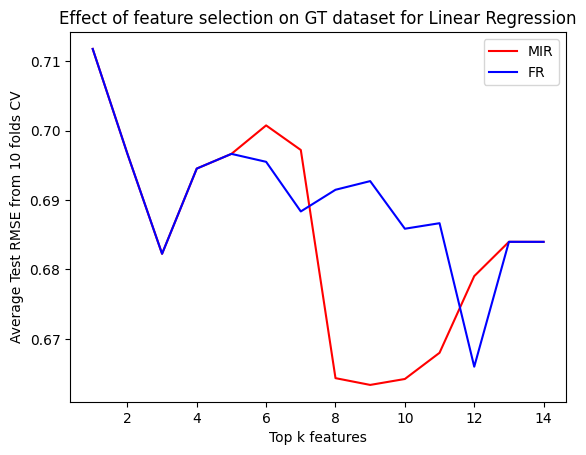

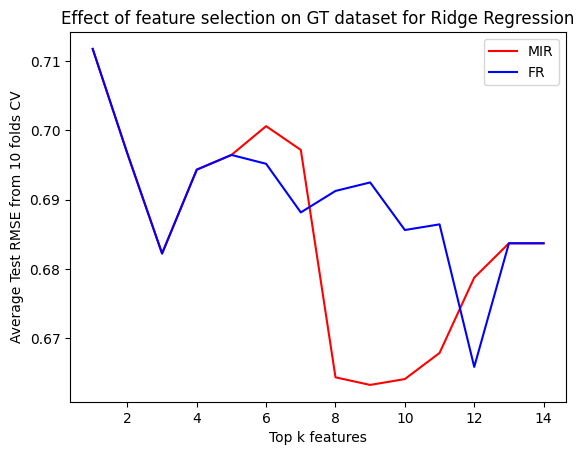

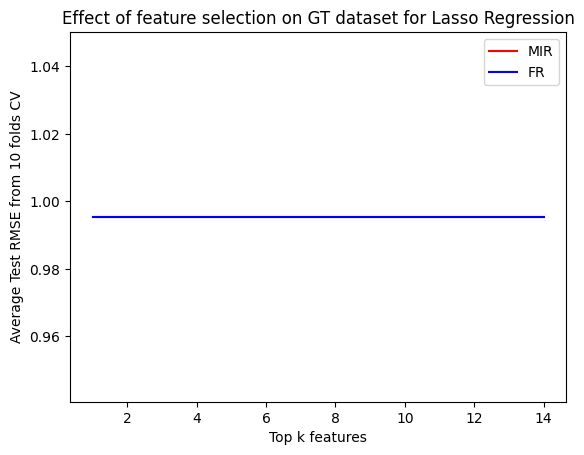

In [ ]:
plt.plot(np.arange(1, len(gt_RMSE_MIR) + 1, 1), np.negative(gt_RMSE_MIR), color = 'r', label = 'MIR')
plt.plot(np.arange(1, len(gt_RMSE_FR) + 1, 1), np.negative(gt_RMSE_FR), color = 'b', label = 'FR')

plt.legend()
plt.xlabel('Top k features')
plt.ylabel('Average Test RMSE from 10 folds CV')
plt.title('Effect of feature selection on GT dataset for Linear Regression')
plt.show()

plt.plot(np.arange(1, len(gt_RMSE_MIR_RR) + 1, 1), np.negative(gt_RMSE_MIR_RR), color = 'r', label = 'MIR')
plt.plot(np.arange(1, len(gt_RMSE_FR_RR) + 1, 1), np.negative(gt_RMSE_FR_RR), color = 'b', label = 'FR')

plt.legend()
plt.xlabel('Top k features')
plt.ylabel('Average Test RMSE from 10 folds CV')
plt.title('Effect of feature selection on GT dataset for Ridge Regression')
plt.show()

plt.plot(np.arange(1, len(gt_RMSE_MIR_LR) + 1, 1), np.negative(gt_RMSE_MIR_LR), color = 'r', label = 'MIR')
plt.plot(np.arange(1, len(gt_RMSE_FR_LR) + 1, 1), np.negative(gt_RMSE_FR_LR), color = 'b', label = 'FR')

plt.legend()
plt.xlabel('Top k features')
plt.ylabel('Average Test RMSE from 10 folds CV')
plt.title('Effect of feature selection on GT dataset for Lasso Regression')
plt.show()

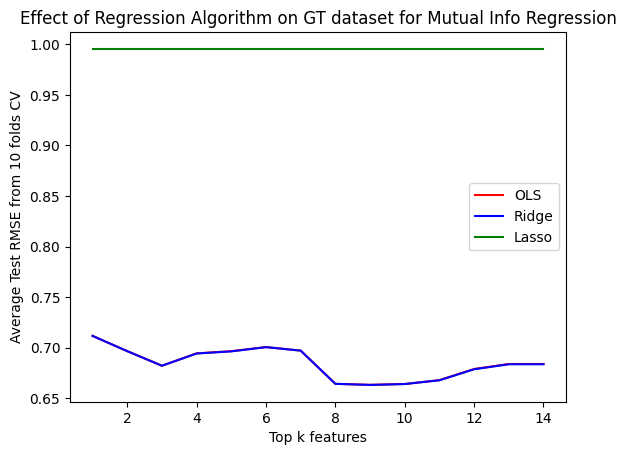

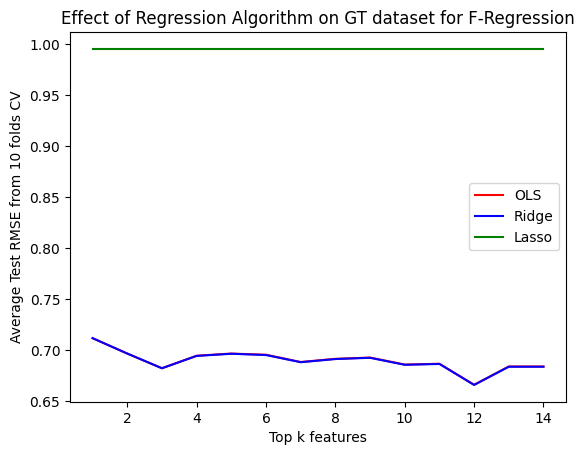

In [ ]:
plt.plot(np.arange(1, len(gt_RMSE_MIR) + 1, 1), np.negative(gt_RMSE_MIR), color = 'r', label = 'OLS')
plt.plot(np.arange(1, len(gt_RMSE_MIR_RR) + 1, 1), np.negative(gt_RMSE_MIR_RR), color = 'b', label = 'Ridge')
plt.plot(np.arange(1, len(gt_RMSE_MIR_LR) + 1, 1), np.negative(gt_RMSE_MIR_LR), color = 'g', label = 'Lasso')

plt.legend()
plt.xlabel('Top k features')
plt.ylabel('Average Test RMSE from 10 folds CV')
plt.title('Effect of Regression Algorithm on GT dataset for Mutual Info Regression')
plt.show()

plt.plot(np.arange(1, len(gt_RMSE_FR) + 1, 1), np.negative(gt_RMSE_FR), color = 'r', label = 'OLS')
plt.plot(np.arange(1, len(gt_RMSE_FR_RR) + 1, 1), np.negative(gt_RMSE_FR_RR), color = 'b', label = 'Ridge')
plt.plot(np.arange(1, len(gt_RMSE_FR_LR) + 1, 1), np.negative(gt_RMSE_FR_LR), color = 'g', label = 'Lasso')

plt.legend()
plt.xlabel('Top k features')
plt.ylabel('Average Test RMSE from 10 folds CV')
plt.title('Effect of Regression Algorithm on GT dataset for F-Regression')
plt.show()

In [ ]:
def readEmissionCSV(year):
    fileName = 'gt_' + str(year) + '.csv'
    gt_yr_data = pd.read_csv(fileName)
    gt_yr_data['year'] = year
    return gt_yr_data

# Read Data
gt_data = readEmissionCSV(2011)
gt_data = gt_data.append(readEmissionCSV(2012))
gt_data = gt_data.append(readEmissionCSV(2013))
gt_data = gt_data.append(readEmissionCSV(2014))
gt_data = gt_data.append(readEmissionCSV(2015))

# Handle categorical data
dum = pd.get_dummies(gt_data['year'], columns=['year'], drop_first=False, prefix = 'year')
gt_data = pd.concat([gt_data, dum], axis=1)

# Split into features and target
X_gt_df = gt_data[['AT', 'AP', 'AH', 'AFDP', 'GTEP', 'TIT', 'TAT', 'TEY', 'CDP', 'year']]
X_gt_df_years = gt_data[['AT', 'AP', 'AH', 'AFDP', 'GTEP', 'TIT', 'TAT', 'TEY', 'CDP', 'year_2011', 'year_2012', 'year_2013', 'year_2014', 'year_2015']]
Y_gt_df = gt_data[['CO']]
Y_gt = gt_data.CO

# Standardize
#scalar = StandardScaler()
#X_gt_S = scalar.fit_transform(X_gt_df)
#X_gt_S_df = pd.DataFrame(X_gt_S, columns = X_gt_df.columns)

#X_gt_S_years = scalar.fit_transform(X_gt_df_years)
#X_gt_S_df_years = pd.DataFrame(X_gt_S_years, columns = X_gt_df_years.columns)

#print('X_gt_S')
#print(X_gt_S_df.describe())

#print('X_gt_S_years')
#print(X_gt_S_df_years.describe())


In [ ]:
from tempfile import mkdtemp
from joblib import Memory
cachedir = mkdtemp()
memory = Memory(cachedir=cachedir, verbose=5)

pipe_standard_linear = Pipeline([
    ('standardize', StandardScaler()),
    ('kbest', SelectKBest()),
    ('model', LinearRegression())
], memory = memory)

pipe_nonstandard_linear = Pipeline([
    ('kbest', SelectKBest()),
    ('model', LinearRegression())
], memory = memory)

param_grid_linear = [
    {
        'kbest__score_func': (mutual_info_regression, f_regression),
        'kbest__k': (1, 2, 3, 4, 5, 6, 7, 8, 9, 10),
    }
]

grid1 = GridSearchCV(pipe_standard_linear, param_grid = param_grid_linear, cv = 10, n_jobs = -1, verbose = 1, 
                     scoring = 'neg_root_mean_squared_error', return_train_score = True).fit(X_gt_df, Y_gt_S)
grid2 = GridSearchCV(pipe_nonstandard_linear, param_grid = param_grid_linear, cv = 10, n_jobs = -1, verbose = 1, 
                     scoring = 'neg_root_mean_squared_error', return_train_score = True).fit(X_gt_df, Y_gt_S)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


KeyboardInterrupt: ignored

In [ ]:
pipe_standard = Pipeline([
    ('standardize', StandardScaler()),
    ('kbest', SelectKBest()),
    ('model', None)
], memory = memory)

pipe_nonstandard = Pipeline([
    ('kbest', SelectKBest()),
    ('model', None)
], memory = memory)

param_grid = [
    {
        'model': (Ridge(random_state=42), Lasso(random_state=42)),
        'model__alpha': (0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0),
        'kbest__score_func': (mutual_info_regression, f_regression),
        'kbest__k': (1, 2, 3, 4, 5, 6, 7, 8, 9, 10),
    }
]

grid3 = GridSearchCV(pipe_standard, param_grid = param_grid, cv = 10, n_jobs = -1, verbose = 1, 
                     scoring = 'neg_root_mean_squared_error', return_train_score = True).fit(X_gt_df, Y_gt_S)
grid4 = GridSearchCV(pipe_nonstandard, param_grid = param_grid, cv = 10, n_jobs = -1, verbose = 1, 
                     scoring = 'neg_root_mean_squared_error', return_train_score = True).fit(X_gt_df, Y_gt_S)

Fitting 10 folds for each of 320 candidates, totalling 3200 fits
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
Fitting 10 folds for each of 320 candidates, totalling 3200 fits
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=8, score_func=<function mutual_info_regression at 0x7f891e4c45e0>),           AT      AP      AH    AFDP    GTEP     TIT     TAT     TEY     CDP  \
0     4.5878  1018.7  83.675  3.5758  23.979  1086.2  549.83  134.67  11.898   
1     4.2932  1018.3  84.235  3.5709  23.951  1086.1  550.05  134.67  11.892   
2     3.9045  1018.4  84.858  3.5828  23.990  1086.5  550.19  135.10  12.042   
3     3.7436  1018.3  85.434  3.5808  

In [ ]:
pipe_standard_linear = Pipeline([
    ('standardize', StandardScaler()),
    ('kbest', SelectKBest()),
    ('model', LinearRegression())
], memory = memory)

pipe_nonstandard_linear = Pipeline([
    ('kbest', SelectKBest()),
    ('model', LinearRegression())
], memory = memory)

param_grid_linear = [
    {
        'kbest__score_func': (mutual_info_regression, f_regression),
        'kbest__k': (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14),
    }
]

grid5 = GridSearchCV(pipe_standard_linear, param_grid = param_grid_linear, cv = 10, n_jobs = -1, verbose = 1, 
                     scoring = 'neg_root_mean_squared_error', return_train_score = True).fit(X_gt_df_years, Y_gt_S)
grid6 = GridSearchCV(pipe_nonstandard_linear, param_grid = param_grid_linear, cv = 10, n_jobs = -1, verbose = 1, 
                     scoring = 'neg_root_mean_squared_error', return_train_score = True).fit(X_gt_df_years, Y_gt_S)

Fitting 10 folds for each of 28 candidates, totalling 280 fits
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading 

___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_tr

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(StandardScaler(),           AT      AP      AH    AFDP    GTEP     TIT     TAT     TEY     CDP  \
0     4.5878  1018.7  83.675  3.5758  23.979  1086.2  549.83  134.67  11.898   
1     4.2932  1018.3  84.235  3.5709  23.951  1086.1  550.05  134.67  11.892   
2     3.9045  1018.4  84.858  3.5828  23.990  1086.5  550.19  135.10  12.042   
3     3.7436  1018.3  85.434  3.5808  23.911  1086.5  550.17  135.03  11.990   
4     3.7516  1017.8  85.182  3.5781  23.917  1085.9  550.00  134.67  11.910   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
7379  3.6268  1028.5  93.200  3.1661  19.087  1037.0  541.59  109.08  10.411   
7380  4.1674  1028.6  94.036  3.1923  19.016  1037.6  542.28..., 
0       -0.904182
1       -0.850611
2       -0.849020
3       -0.946415
4       -0.930328
           ...   
36728    3.8

___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_tr

___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_tr

___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_tr

___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_tr

___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_tr

________________________________________________fit_transform_one - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=3, score_func=<function f_regression at 0x7fb1105c3430>), array([[-1.706966, ..., -0.536268],
       ...,
       [-1.511903, ...,  1.864738]]), 
0       -0.904182
1       -0.850611
2       -0.849020
3       -0.946415
4       -0.930328
           ...   
36728    3.809943
36729    3.876679
36730    3.996008
36731    0.415856
36732    4.246601
Name: CO, Length: 33060, dtype: float64, 
None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_tra

___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=5, score_func=<function mutual_info_regression at 0x7fa7005788b0>), array([[-1.817248, ..., -0.536268],
       ...,
       [-1.623428, ...,  1.864738]]), 
0       -0.904182
1       -0.850611
2       -0.849020
3       -0.946415
4       -0.930328
           ...   
36728    3.809943
36729    3.876679
36730    3.996008
36731    0.415856
36732    4.246601
Name: CO, Length: 33060, dtype: float64, 
None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 5.3s, 0.1min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory

___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=6, score_func=<function mutual_info_regression at 0x7ffd185788b0>), array([[-1.698098, ..., -0.536268],
       ...,
       [-1.50426 , ...,  1.864738]]), 
0       -0.904182
1       -0.850611
2       -0.849020
3       -0.946415
4       -0.930328
           ...   
36728    3.809943
36729    3.876679
36730    3.996008
36731    0.415856
36732    4.246601
Name: CO, Length: 33060, dtype: float64, 
None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 5.8s, 0.1min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(score_func=<function mutual_info_regression at 0x7f8831821280>),           AT      AP      AH    AFDP    GTEP     TIT     TAT     TEY     CDP  \
0     4.5878  1018.7  83.675  3.5758  23.979  1086.2  549.83  134.67  11.898   
1     4.2932  1018.3  84.235  3.5709  23.951  1086.1  550.05  134.67  11.892   
2     3.9045  1018.4  84.858  3.5828  23.990  1086.5  550.19  135.10  12.042   
3     3.7436  1018.3  85.434  3.5808  23.911  1086.5  550.17  135.03  11.990   
4     3.7516  1017.8  85.182  3.5781  23.917  1085.9  550.00  134.67  11.910   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
7379  3.6268  1028.5  93.200  3.1661  19.087  1037.0  541.59  109.08  10.411   
7380  4.1674  1028.6  94.036  3.1923  19.016  1037.6  542.28..., 
0       -0.904182
1       -0.850611
2       -0.849020
3      

In [ ]:
pipe_standard = Pipeline([
    ('standardize', StandardScaler()),
    ('kbest', SelectKBest()),
    ('model', None)
], memory = memory)

pipe_nonstandard = Pipeline([
    ('kbest', SelectKBest()),
    ('model', None)
], memory = memory)

param_grid = [
    {
        'model': (Ridge(random_state=42), Lasso(random_state=42)),
        'model__alpha': (0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0),
        'kbest__score_func': (mutual_info_regression, f_regression),
        'kbest__k': (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14),
    }
]

grid7 = GridSearchCV(pipe_standard, param_grid = param_grid, cv = 10, n_jobs = -1, verbose = 1, 
                     scoring = 'neg_root_mean_squared_error', return_train_score = True).fit(X_gt_df_years, Y_gt_S)
grid8 = GridSearchCV(pipe_nonstandard, param_grid = param_grid, cv = 10, n_jobs = -1, verbose = 1, 
                     scoring = 'neg_root_mean_squared_error', return_train_score = True).fit(X_gt_df_years, Y_gt_S)

Fitting 10 folds for each of 448 candidates, totalling 4480 fits
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=1, score_func=<function mutual_info_regression at 0x7ff6005488b0>),            AT      AP      AH  ...  year_2013  year_2014  year_2015
0      4.5878  1018.7  83.675  ...          0          0          0
1      4.2932  1018.3  84.235  ...          0          0          0
2      3.9045  1018.4  84.858  ...          0          0          0
3      3.7436  1018.3  85.434  ...          0          0          0
4      3.7516  1017.8  85.182  ...          0          0          0
...       ...     ...     ...  ...        ...        ...        ...
3706  26.7140  1010.3  64.507  ...          0          0          1
3707  29.0240  1010.5  60.526  ...          0          0          1
3708  30.4500  1010.7  54.090  ...          0          0          1
3709  30.3300  10

________________________________________________fit_transform_one - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=11, score_func=<function f_regression at 0x7f8e68a43430>), array([[-1.744881, ..., -0.355589],
       ...,
       [ 1.721612, ...,  2.812232]]), 
0       -0.904182
1       -0.850611
2       -0.849020
3       -0.946415
4       -0.930328
           ...   
33055   -0.287393
33056   -0.178538
33057   -0.277626
33058   -0.193565
33059   -0.265428
Name: CO, Length: 33060, dtype: float64, 
None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_tr

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=2, score_func=<function mutual_info_regression at 0x7fcdc02b08b0>),           AT      AP      AH  ...  year_2013  year_2014  year_2015
0     4.5878  1018.7  83.675  ...          0          0          0
1     4.2932  1018.3  84.235  ...          0          0          0
2     3.9045  1018.4  84.858  ...          0          0          0
3     3.7436  1018.3  85.434  ...          0          0          0
4     3.7516  1017.8  85.182  ...          0          0          0
...      ...     ...     ...  ...        ...        ...        ...
7379  3.6268  1028.5  93.200  ...          0          0          1
7380  4.1674  1028.6  94.036  ...          0          0          1
7381  5.4820  1028.5  95.219  ...          0          0          1
7382  5.8837  1028.7  94.200  ...          0          0          1
7383  6.0392  1028.8  94.

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=7, score_func=<function f_regression at 0x7fb1105c3430>),           AT      AP      AH  ...  year_2013  year_2014  year_2015
0     4.5878  1018.7  83.675  ...          0          0          0
1     4.2932  1018.3  84.235  ...          0          0          0
2     3.9045  1018.4  84.858  ...          0          0          0
3     3.7436  1018.3  85.434  ...          0          0          0
4     3.7516  1017.8  85.182  ...          0          0          0
...      ...     ...     ...  ...        ...        ...        ...
7379  3.6268  1028.5  93.200  ...          0          0          1
7380  4.1674  1028.6  94.036  ...          0          0          1
7381  5.4820  1028.5  95.219  ...          0          0          1
7382  5.8837  1028.7  94.200  ...          0          0          1
7383  6.0392  1028.8  94.547  ...  

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=5, score_func=<function mutual_info_regression at 0x7fd5c84388b0>),           AT      AP      AH  ...  year_2013  year_2014  year_2015
0     4.5878  1018.7  83.675  ...          0          0          0
1     4.2932  1018.3  84.235  ...          0          0          0
2     3.9045  1018.4  84.858  ...          0          0          0
3     3.7436  1018.3  85.434  ...          0          0          0
4     3.7516  1017.8  85.182  ...          0          0          0
...      ...     ...     ...  ...        ...        ...        ...
7379  3.6268  1028.5  93.200  ...          0          0          1
7380  4.1674  1028.6  94.036  ...          0          0          1
7381  5.4820  1028.5  95.219  ...          0          0          1
7382  5.8837  1028.7  94.200  ...          0          0          1
7383  6.0392  1028.8  94.

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=11, score_func=<function f_regression at 0x7ffcd852b430>),           AT      AP      AH  ...  year_2013  year_2014  year_2015
0     4.5878  1018.7  83.675  ...          0          0          0
1     4.2932  1018.3  84.235  ...          0          0          0
2     3.9045  1018.4  84.858  ...          0          0          0
3     3.7436  1018.3  85.434  ...          0          0          0
4     3.7516  1017.8  85.182  ...          0          0          0
...      ...     ...     ...  ...        ...        ...        ...
7379  3.6268  1028.5  93.200  ...          0          0          1
7380  4.1674  1028.6  94.036  ...          0          0          1
7381  5.4820  1028.5  95.219  ...          0          0          1
7382  5.8837  1028.7  94.200  ...          0          0          1
7383  6.0392  1028.8  94.547  ... 

___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_tr

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(score_func=<function mutual_info_regression at 0x7fa7005788b0>),           AT      AP      AH  ...  year_2013  year_2014  year_2015
0     4.5878  1018.7  83.675  ...          0          0          0
1     4.2932  1018.3  84.235  ...          0          0          0
2     3.9045  1018.4  84.858  ...          0          0          0
3     3.7436  1018.3  85.434  ...          0          0          0
4     3.7516  1017.8  85.182  ...          0          0          0
...      ...     ...     ...  ...        ...        ...        ...
7379  3.6268  1028.5  93.200  ...          0          0          1
7380  4.1674  1028.6  94.036  ...          0          0          1
7381  5.4820  1028.5  95.219  ...          0          0          1
7382  5.8837  1028.7  94.200  ...          0          0          1
7383  6.0392  1028.8  94.547  

/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 253.73202824003783, tolerance: 3.489458514881779
  model = cd_fast.enet_coordinate_descent(
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 323.40752484161203, tolerance: 3.4027038604186974
  model = cd_fast.enet_coordinate_descent(
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.366110724191458, tolerance: 3.4027038604186974
  model = cd_fast.enet_coordinate_descent(
/Users/madhavsankar/opt/anaconda3/lib/python3.9/

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=14,
            score_func=<function mutual_info_regression at 0x7ff6005488b0>), 
          AT      AP      AH  ...  year_2013  year_2014  year_2015
0     4.5878  1018.7  83.675  ...          0          0          0
1     4.2932  1018.3  84.235  ...          0          0          0
2     3.9045  1018.4  84.858  ...          0          0          0
3     3.7436  1018.3  85.434  ...          0          0          0
4     3.7516  1017.8  85.182  ...          0          0          0
...      ...     ...     ...  ...        ...        ...        ...
7379  3.6268  1028.5  93.200  ...          0          0          1
7380  4.1674  1028.6  94.036  ...          0          0          1
7381  5.4820  1028.5  95.219  ...          0          0          1
7382  5.8837  1028.7  94.200  ...          0          0          1
7383  6.039

/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 51.81680843488721, tolerance: 3.3296148031495907
  model = cd_fast.enet_coordinate_descent(
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 73.39923901150723, tolerance: 3.324532579074931
  model = cd_fast.enet_coordinate_descent(


___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_tr

/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 317.6185111450377, tolerance: 3.489458514881779
  model = cd_fast.enet_coordinate_descent(
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.372701405953194, tolerance: 3.1997832011137284
  model = cd_fast.enet_coordinate_descent(
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.01901594341507, tolerance: 3.146867178164331
  model = cd_fast.enet_coordinate_descent(
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site

/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.210024142765178, tolerance: 3.4027038604186974
  model = cd_fast.enet_coordinate_descent(
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 280.2636602872808, tolerance: 3.3296148031495907
  model = cd_fast.enet_coordinate_descent(
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.527949432942478, tolerance: 3.336842178704525
  model = cd_fast.enet_coordinate_descent(
/Users/madhavsankar/opt/anaconda3/lib/python3.9/si

[Memory]0.1s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_tr

/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 404.41959473209135, tolerance: 3.4027038604186974
  model = cd_fast.enet_coordinate_descent(
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 335.5541853566265, tolerance: 3.336842178704525
  model = cd_fast.enet_coordinate_descent(
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 440.64682350201656, tolerance: 3.2642173234339382
  model = cd_fast.enet_coordinate_descent(
/Users/madhavsankar/opt/anaconda3/lib/python3.9/

[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_tr

/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 818.0125705086939, tolerance: 3.1997832011137284
  model = cd_fast.enet_coordinate_descent(
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.788206604389416, tolerance: 3.2642173234339382
  model = cd_fast.enet_coordinate_descent(
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19.796776146204138, tolerance: 3.432197641283393
  model = cd_fast.enet_coordinate_descent(
/Users/madhavsankar/opt/anaconda3/lib/python3.9/s

[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_tr

/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 330.4505154595481, tolerance: 3.146867178164331
  model = cd_fast.enet_coordinate_descent(
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.629139301927353, tolerance: 3.1045305597316086
  model = cd_fast.enet_coordinate_descent(
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.5566191365342092, tolerance: 3.489458514881779
  model = cd_fast.enet_coordinate_descent(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_tr

/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.221458806638111, tolerance: 3.336842178704525
  model = cd_fast.enet_coordinate_descent(


_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0mi

/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 331.7767236586533, tolerance: 3.3296148031495907
  model = cd_fast.enet_coordinate_descent(
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 393.72514267387487, tolerance: 3.324532579074931
  model = cd_fast.enet_coordinate_descent(
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.3921437612716545, tolerance: 3.4027038604186974
  model = cd_fast.enet_coordinate_descent(
/Users/madhavsankar/opt/anaconda3/lib/python3.9/

___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_tr

/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 761.8963082769933, tolerance: 3.1997832011137284
  model = cd_fast.enet_coordinate_descent(
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1566.7201203024542, tolerance: 3.4027038604186974
  model = cd_fast.enet_coordinate_descent(
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1212.3368524144744, tolerance: 3.2642173234339382
  model = cd_fast.enet_coordinate_descent(
/Users/madhavsankar/opt/anaconda3/lib/python3.9

___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_tr

/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1025.7972136210938, tolerance: 3.3296148031495907
  model = cd_fast.enet_coordinate_descent(
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 184.43533546949948, tolerance: 3.1997832011137284
  model = cd_fast.enet_coordinate_descent(
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 820.3094397271107, tolerance: 3.489458514881779
  model = cd_fast.enet_coordinate_descent(
/Users/madhavsankar/opt/anaconda3/lib/python3.9/

/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.253506860071866, tolerance: 3.146867178164331
  model = cd_fast.enet_coordinate_descent(
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 338.31392169860555, tolerance: 3.2642173234339382
  model = cd_fast.enet_coordinate_descent(
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 648.2835409072322, tolerance: 3.336842178704525
  model = cd_fast.enet_coordinate_descent(
/Users/madhavsankar/opt/anaconda3/lib/python3.9/si

[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_tr

/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1075.1478192693066, tolerance: 3.336842178704525
  model = cd_fast.enet_coordinate_descent(


_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]

/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1206.2281269020923, tolerance: 3.146867178164331
  model = cd_fast.enet_coordinate_descent(
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 285.4592872523408, tolerance: 3.1045305597316086
  model = cd_fast.enet_coordinate_descent(
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4596.542655446347, tolerance: 3.432197641283393
  model = cd_fast.enet_coordinate_descent(
/Users/madhavsankar/opt/anaconda3/lib/python3.9/si

/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1072.591632580401, tolerance: 3.2642173234339382
  model = cd_fast.enet_coordinate_descent(
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 788.8737751972294, tolerance: 3.324532579074931
  model = cd_fast.enet_coordinate_descent(
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 939.7984997209933, tolerance: 3.3296148031495907
  model = cd_fast.enet_coordinate_descent(
/Users/madhavsankar/opt/anaconda3/lib/python3.9/si

___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_tr

[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectKBest(k=12,
            score_func=<function mutual_info_regression at 0x7f8831821280>), 
array([[-1.762362, ..., -0.50159 ],
       ...,
       [-1.567474, ...,  1.993659]]), 
0       -0.904182
1       -0.850611
2       -0.849020
3       -0.946415
4       -0.930328
           ...   
36728    3.809943
36729    3.876679
36730    3.996008
36731    0.415856
36732    4.246601
Name: CO, Length: 36733, dtype: float64, 
None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 3.4s, 0.1min
Fitting 10 folds for each of 448 candidates, totalling 4480 fits
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
__________________________________

[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_tr

/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.452893791662063, tolerance: 3.1997832011137284
  model = cd_fast.enet_coordinate_descent(


___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_tr

/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.452893791662063, tolerance: 3.1997832011137284
  model = cd_fast.enet_coordinate_descent(


___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_tr

/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19.392160647568744, tolerance: 3.1997832011137284
  model = cd_fast.enet_coordinate_descent(
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19.392160647568744, tolerance: 3.1997832011137284
  model = cd_fast.enet_coordinate_descent(


[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_tr

/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.694177120061795, tolerance: 3.1997832011137284
  model = cd_fast.enet_coordinate_descent(
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4665.2294709822345, tolerance: 3.489458514881779
  model = cd_fast.enet_coordinate_descent(
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 188.9810755510498, tolerance: 3.1997832011137284
  model = cd_fast.enet_coordinate_descent(
/Users/madhavsankar/opt/anaconda3/lib/python3.9/

/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 564.1047167470169, tolerance: 3.489458514881779
  model = cd_fast.enet_coordinate_descent(
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3516.250618565782, tolerance: 3.432197641283393
  model = cd_fast.enet_coordinate_descent(
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38.57450190028612, tolerance: 3.1045305597316086
  model = cd_fast.enet_coordinate_descent(
/Users/madhavsankar/opt/anaconda3/lib/python3.9/sit

/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 658.5081746878041, tolerance: 3.2642173234339382
  model = cd_fast.enet_coordinate_descent(
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 569.5685088832961, tolerance: 3.146867178164331
  model = cd_fast.enet_coordinate_descent(
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1860.6447450423711, tolerance: 3.3296148031495907
  model = cd_fast.enet_coordinate_descent(
/Users/madhavsankar/opt/anaconda3/lib/python3.9/s

[Memory]0.1s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_tr

/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2353.047387139298, tolerance: 3.432197641283393
  model = cd_fast.enet_coordinate_descent(
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 99.16406953696242, tolerance: 3.1997832011137284
  model = cd_fast.enet_coordinate_descent(


t_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0m

/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.163084059200628, tolerance: 3.324532579074931
  model = cd_fast.enet_coordinate_descent(
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5047.860920903593, tolerance: 3.489458514881779
  model = cd_fast.enet_coordinate_descent(
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5309.816215224914, tolerance: 3.1045305597316086
  model = cd_fast.enet_coordinate_descent(
/Users/madhavsankar/opt/anaconda3/lib/python3.9/sit

/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 397.99015214658357, tolerance: 3.146867178164331
  model = cd_fast.enet_coordinate_descent(
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 436.0625175177174, tolerance: 3.3296148031495907
  model = cd_fast.enet_coordinate_descent(
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19.71184425593856, tolerance: 3.324532579074931
  model = cd_fast.enet_coordinate_descent(
/Users/madhavsankar/opt/anaconda3/lib/python3.9/si

/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6171.974026264145, tolerance: 3.336842178704525
  model = cd_fast.enet_coordinate_descent(
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5490.4395011358865, tolerance: 3.1997832011137284
  model = cd_fast.enet_coordinate_descent(
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.781054164352099, tolerance: 3.4027038604186974
  model = cd_fast.enet_coordinate_descent(
/Users/madhavsankar/opt/anaconda3/lib/python3.9/s

/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.359587165032281, tolerance: 3.336842178704525
  model = cd_fast.enet_coordinate_descent(
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.274632034566821, tolerance: 3.146867178164331
  model = cd_fast.enet_coordinate_descent(
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6005.175423132374, tolerance: 3.2642173234339382
  model = cd_fast.enet_coordinate_descent(
/Users/madhavsankar/opt/anaconda3/lib/python3.9/sit

/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6711.329631005508, tolerance: 3.432197641283393
  model = cd_fast.enet_coordinate_descent(
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.6036869844956527, tolerance: 3.2642173234339382
  model = cd_fast.enet_coordinate_descent(
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6037.490279201123, tolerance: 3.3296148031495907
  model = cd_fast.enet_coordinate_descent(
/Users/madhavsankar/opt/anaconda3/lib/python3.9/s

___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_tr

/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6063.3578467963225, tolerance: 3.3296148031495907
  model = cd_fast.enet_coordinate_descent(
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 93.32533364413212, tolerance: 3.4027038604186974
  model = cd_fast.enet_coordinate_descent(


 cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s

/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6562.2958955092545, tolerance: 3.489458514881779
  model = cd_fast.enet_coordinate_descent(
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6117.201972512656, tolerance: 3.1045305597316086
  model = cd_fast.enet_coordinate_descent(
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5396.806113466001, tolerance: 3.432197641283393
  model = cd_fast.enet_coordinate_descent(
/Users/madhavsankar/opt/anaconda3/lib/python3.9/si

/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6171.097329519126, tolerance: 3.324532579074931
  model = cd_fast.enet_coordinate_descent(
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6246.770446532352, tolerance: 3.4027038604186974
  model = cd_fast.enet_coordinate_descent(
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6017.23000451367, tolerance: 3.3296148031495907
  model = cd_fast.enet_coordinate_descent(
/Users/madhavsankar/opt/anaconda3/lib/python3.9/sit

___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_tr

/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55.52718685882792, tolerance: 3.4027038604186974
  model = cd_fast.enet_coordinate_descent(
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 93.78215319361334, tolerance: 3.336842178704525
  model = cd_fast.enet_coordinate_descent(
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.675396475451635, tolerance: 3.2642173234339382
  model = cd_fast.enet_coordinate_descent(
/Users/madhavsankar/opt/anaconda3/lib/python3.9/si

/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 447.81556557546355, tolerance: 3.2642173234339382
  model = cd_fast.enet_coordinate_descent(
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1709.3603661729276, tolerance: 3.4027038604186974
  model = cd_fast.enet_coordinate_descent(
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5976.164721745387, tolerance: 3.2642173234339382
  model = cd_fast.enet_coordinate_descent(
/Users/madhavsankar/opt/anaconda3/lib/python3.9

[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_tr

/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4310.379058625164, tolerance: 3.432197641283393
  model = cd_fast.enet_coordinate_descent(
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.274465110504025, tolerance: 3.146867178164331
  model = cd_fast.enet_coordinate_descent(
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 392.94213443744775, tolerance: 3.1997832011137284
  model = cd_fast.enet_coordinate_descent(
/Users/madhavsankar/opt/anaconda3/lib/python3.9/si

[Memory]0.0s, 0.0min    : Loading _fit_transform_one...
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min


In [ ]:
result1 = pd.DataFrame(grid1.cv_results_)[['mean_test_score', 'mean_train_score', 'param_kbest__score_func', 'param_kbest__k']]
result1['Standardize'] = True
result1['param_model'] = 'LinearRegression()'
result1['year'] = 'Direct'

result2 = pd.DataFrame(grid2.cv_results_)[['mean_test_score', 'mean_train_score', 'param_kbest__score_func', 'param_kbest__k']]
result2['Standardize'] = False
result2['param_model'] = 'LinearRegression()'
result2['year'] = 'Direct'

result3 = pd.DataFrame(grid3.cv_results_)[['mean_test_score', 'mean_train_score', 'param_model', 'param_model__alpha', 'param_kbest__score_func', 'param_kbest__k']]
result3['Standardize'] = True
result3['year'] = 'Direct'

result4 = pd.DataFrame(grid4.cv_results_)[['mean_test_score', 'mean_train_score', 'param_model', 'param_model__alpha', 'param_kbest__score_func', 'param_kbest__k']]
result4['Standardize'] = False
result4['year'] = 'Direct'

result5 = pd.DataFrame(grid5.cv_results_)[['mean_test_score', 'mean_train_score', 'param_kbest__score_func', 'param_kbest__k']]
result5['Standardize'] = True
result5['param_model'] = 'LinearRegression()'
result5['year'] = 'One Hot'

result6 = pd.DataFrame(grid6.cv_results_)[['mean_test_score', 'mean_train_score', 'param_kbest__score_func', 'param_kbest__k']]
result6['Standardize'] = False
result6['param_model'] = 'LinearRegression()'
result6['year'] = 'One Hot'

result7 = pd.DataFrame(grid7.cv_results_)[['mean_test_score', 'mean_train_score', 'param_model', 'param_model__alpha', 'param_kbest__score_func', 'param_kbest__k']]
result7['Standardize'] = True
result7['year'] = 'One Hot'

result8 = pd.DataFrame(grid8.cv_results_)[['mean_test_score', 'mean_train_score', 'param_model', 'param_model__alpha', 'param_kbest__score_func', 'param_kbest__k']]
result8['Standardize'] = False
result8['year'] = 'One Hot'

results = pd.concat([result1, result2, result3, result4, result5, result6, result7, result8])
results = results.sort_values(by=['mean_test_score'], ascending = False).reset_index(drop = True)
results.to_csv('GT.csv', sep='\t', encoding='utf-8')

Mean Squared Error (MSE): 0.33048714599313356
Mean Absolute Error (MAE): 0.3337766374622279
R2-score: 0.6190290221162631


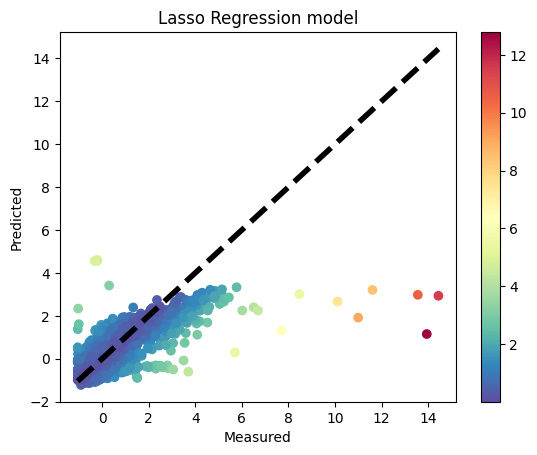

In [ ]:


# Standardize the features
scaler = StandardScaler()
X_gt_S_std = scaler.fit_transform(X_gt_S)
X_test_std = scaler.transform(X_test)

# Train the Lasso Regression model
lasso = Lasso(alpha=0.01)
lasso.fit(X_gt_S_std, Y_gt_S)

# Generate predictions for the test set
y_pred = lasso.predict(X_test_std)

# Calculate absolute difference between predicted and actual values
diff = np.abs(y_test - y_pred)
# Calculate MSE, MAE, and R2-score
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R2-score:", r2)
# Plot predicted vs. actual values with color variation based on prediction accuracy
fig, ax = plt.subplots()
scatter = ax.scatter(y_test, y_pred, c=diff, cmap='Spectral_r')
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.title("Lasso Regression model")
plt.colorbar(scatter)
plt.show()


In [ ]:
import statsmodels.api as sm
 
lm_fit = sm.OLS(Y_gt_S, sm.add_constant(X_gt_S)).fit()
print(lm_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                     CO   R-squared:                       0.599
Model:                            OLS   Adj. R-squared:                  0.599
Method:                 Least Squares   F-statistic:                     4218.
Date:                Sun, 09 Apr 2023   Prob (F-statistic):               0.00
Time:                        20:55:25   Log-Likelihood:                -35341.
No. Observations:               36733   AIC:                         7.071e+04
Df Residuals:                   36719   BIC:                         7.083e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.005      0.450      0.6

In [ ]:
lm_fit.pvalues

const         6.529521e-01
AT            9.916207e-57
AP            1.777659e-02
AH            9.750116e-01
AFDP          7.233009e-01
GTEP          4.559484e-01
TIT           4.161151e-02
TAT          5.163577e-126
TEY          1.268765e-137
CDP           4.994120e-11
year_2011     5.238544e-01
year_2012     5.238544e-01
year_2013     5.238544e-01
year_2014     5.238544e-01
year_2015     5.238544e-01
dtype: float64

In [ ]:
# Best previously was top 9 with Mutual-Info-Regression
X_gt_df_topk = SelectKBest(score_func = mutual_info_regression, k = 9).fit_transform(X_gt_df_years, Y_gt_S)

pipeline = Pipeline([
    ('PR', PolynomialFeatures()),
    ('standardize', StandardScaler()),
    ('model', None)
])

param_grid = [
    {
        'model': (Ridge(random_state=42), Lasso(random_state=42)),
        'PR__degree': (1, 2, 3, 4),
        'model__alpha': (0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0)
    }
]

grid = GridSearchCV(pipeline, param_grid = param_grid, cv = 10, n_jobs = -1, verbose = 3, 
                     scoring = 'neg_root_mean_squared_error', return_train_score = True).fit(X_gt_df_topk, Y_gt_S)

NameError: ignored

<ipython-input-47-7833885ccd9f>:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  score.append((poly_result.loc[poly_result['param_PR__degree'] == i]).max().mean_test_score)
<ipython-input-47-7833885ccd9f>:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  train.append((poly_result.loc[poly_result['param_PR__degree'] == i]).max().mean_train_score)
<ipython-input-47-7833885ccd9f>:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  score.append((poly_result.loc[poly_result['param_PR__degree

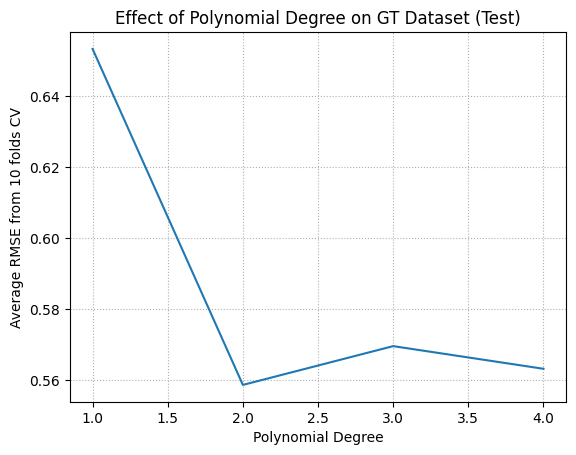

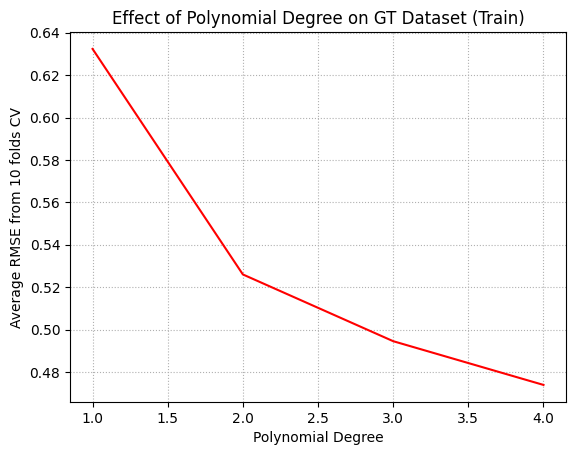

In [ ]:
poly_result = pd.DataFrame(grid.cv_results_)[['mean_test_score','mean_train_score','param_model', 'param_PR__degree','param_model__alpha']]
results = poly_result.sort_values(by=['mean_test_score'], ascending = False).reset_index(drop = True)
results.to_csv('gt_PR.csv', sep='\t', encoding='utf-8')
score = []
train = []
alpha = []
degree_list = np.arange(1,5,1)

for i in degree_list:
    score.append((poly_result.loc[poly_result['param_PR__degree'] == i]).max().mean_test_score)
    train.append((poly_result.loc[poly_result['param_PR__degree'] == i]).max().mean_train_score)
    alpha.append(float(poly_result['param_model__alpha'][
        (poly_result.loc[poly_result['param_PR__degree'] == i])
        [['mean_test_score']].idxmax()].to_numpy()))

plt.plot(degree_list, np.negative(score))
plt.grid(linestyle=':')
plt.xlabel('Polynomial Degree')
plt.ylabel('Average RMSE from 10 folds CV')
plt.title('Effect of Polynomial Degree on GT Dataset (Test)')
plt.show()

plt.plot(degree_list, np.negative(train), 'r')
plt.grid(linestyle=':')
plt.xlabel('Polynomial Degree')
plt.ylabel('Average RMSE from 10 folds CV')
plt.title('Effect of Polynomial Degree on GT Dataset (Train)')
plt.show()

In [ ]:
selk = SelectKBest(score_func = mutual_info_regression, k = 9)
X_gt_df_topk = selk.fit_transform(X_gt_df_years, Y_gt_S)
column_names = X_gt_df_years.columns[selk.get_support()]

b_params = grid.best_estimator_.get_params()
b_coefs = b_params['model'].coef_
b_feature_name = list(column_names)
b_names = b_params['PR'].get_feature_names(b_feature_name)
b_sorted_indice = np.argsort(-abs(b_coefs))
salient_features =[b_names[i] for i in b_sorted_indice[:5]]
print ('Top 5 Salient features (GT):',salient_features)

AttributeError: ignored

Mean Squared Error (MSE): 0.2735816797145129
Mean Absolute Error (MAE): 0.2469708598552611
R2-score: 0.7424224243374519


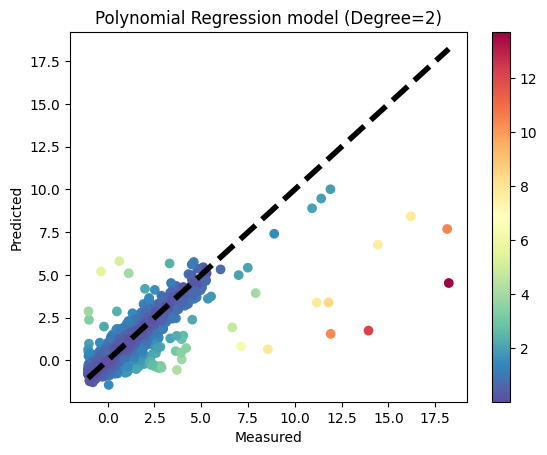

In [ ]:

# Split the data into train and test sets with random_state=42
X_train, X_test, y_train, y_test = train_test_split(X_gt_S, Y_gt_S, test_size=0.2, random_state=42)

# Create polynomial features with degree=2
poly_features = PolynomialFeatures(degree=2)
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.transform(X_test)

# Standardize the features
scaler = StandardScaler()
X_train_poly_std = scaler.fit_transform(X_train_poly)
X_test_poly_std = scaler.transform(X_test_poly)

# Train the Ridge Regression model with alpha=0.1
ridge = Ridge(alpha=0.1)
ridge.fit(X_train_poly_std, y_train)

# Generate predictions for the test set
y_pred = ridge.predict(X_test_poly_std)

# Calculate absolute difference between predicted and actual values
diff = np.abs(y_test - y_pred)
# Calculate MSE, MAE, and R2-score
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R2-score:", r2)
# Plot predicted vs. actual values with color variation based on prediction accuracy
fig, ax = plt.subplots()
scatter = ax.scatter(y_test, y_pred, c=diff, cmap='Spectral_r')
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.title("Polynomial Regression model (Degree=2)")
plt.colorbar(scatter)
plt.show()


In [ ]:
pipeline = Pipeline([
    ('kbest', SelectKBest()),
    ('PR', PolynomialFeatures(degree = 3)),
    ('standardize', StandardScaler()),
    ('model', Ridge(random_state=42))
])

param_grid = [
    {
        'model__alpha': (0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0),
        'kbest__score_func': (mutual_info_regression, f_regression),
        'kbest__k': (5, 6, 7),
    }
]

grid = GridSearchCV(pipeline, param_grid = param_grid, cv = 10, n_jobs = -1, verbose = 3, 
                     scoring = 'neg_root_mean_squared_error', return_train_score = True).fit(X_diamond_new, Y_diamond_S)
print('Average Test RMSE with inverse feature:', grid.best_score_)

Fitting 10 folds for each of 48 candidates, totalling 480 fits
Average Test RMSE with inverse feature: -0.17403316392998497


In [ ]:
print(grid.best_estimator_.get_params())

{'memory': None, 'steps': [('kbest', SelectKBest(k=7, score_func=<function mutual_info_regression at 0x7f8831821280>)), ('PR', PolynomialFeatures(degree=3)), ('standardize', StandardScaler()), ('model', Ridge(alpha=1000.0, random_state=42))], 'verbose': False, 'kbest': SelectKBest(k=7, score_func=<function mutual_info_regression at 0x7f8831821280>), 'PR': PolynomialFeatures(degree=3), 'standardize': StandardScaler(), 'model': Ridge(alpha=1000.0, random_state=42), 'kbest__k': 7, 'kbest__score_func': <function mutual_info_regression at 0x7f8831821280>, 'PR__degree': 3, 'PR__include_bias': True, 'PR__interaction_only': False, 'PR__order': 'C', 'standardize__copy': True, 'standardize__with_mean': True, 'standardize__with_std': True, 'model__alpha': 1000.0, 'model__copy_X': True, 'model__fit_intercept': True, 'model__max_iter': None, 'model__normalize': False, 'model__random_state': 42, 'model__solver': 'auto', 'model__tol': 0.001}
[CV 6/10] END kbest__k=5, kbest__score_func=<function mutua

[CV 4/10] END kbest__k=5, kbest__score_func=<function mutual_info_regression at 0x7fe5605588b0>, model__alpha=0.0001;, score=(train=-0.240, test=-0.431) total time=   5.3s
[CV 5/10] END kbest__k=5, kbest__score_func=<function mutual_info_regression at 0x7fe5605588b0>, model__alpha=0.001;, score=(train=-0.207, test=-46.370) total time=   5.2s
[CV 4/10] END kbest__k=5, kbest__score_func=<function mutual_info_regression at 0x7fe5605588b0>, model__alpha=0.01;, score=(train=-0.243, test=-0.427) total time=   5.6s
[CV 2/10] END kbest__k=5, kbest__score_func=<function mutual_info_regression at 0x7fe5605588b0>, model__alpha=0.1;, score=(train=-0.271, test=-0.207) total time=   5.6s
[CV 10/10] END kbest__k=5, kbest__score_func=<function mutual_info_regression at 0x7fe5605588b0>, model__alpha=0.1;, score=(train=-0.274, test=-0.438) total time=   5.7s
[CV 8/10] END kbest__k=5, kbest__score_func=<function mutual_info_regression at 0x7fe5605588b0>, model__alpha=1.0;, score=(train=-0.281, test=-0.05

[CV 2/10] END kbest__k=5, kbest__score_func=<function mutual_info_regression at 0x7fdba82788b0>, model__alpha=0.0001;, score=(train=-0.268, test=-0.206) total time=   4.9s
[CV 2/10] END kbest__k=5, kbest__score_func=<function mutual_info_regression at 0x7fdba82788b0>, model__alpha=0.001;, score=(train=-0.269, test=-0.205) total time=   5.1s
[CV 8/10] END kbest__k=5, kbest__score_func=<function mutual_info_regression at 0x7fdba82788b0>, model__alpha=0.001;, score=(train=-0.277, test=-0.060) total time=   5.5s
[CV 10/10] END kbest__k=5, kbest__score_func=<function mutual_info_regression at 0x7fdba82788b0>, model__alpha=0.01;, score=(train=-0.273, test=-0.352) total time=   5.4s
[CV 8/10] END kbest__k=5, kbest__score_func=<function mutual_info_regression at 0x7fdba82788b0>, model__alpha=0.1;, score=(train=-0.279, test=-0.058) total time=   5.4s
[CV 5/10] END kbest__k=5, kbest__score_func=<function mutual_info_regression at 0x7fdba82788b0>, model__alpha=1.0;, score=(train=-0.210, test=-4.0

[CV 8/10] END kbest__k=5, kbest__score_func=<function mutual_info_regression at 0x7fbd803208b0>, model__alpha=0.0001;, score=(train=-0.276, test=-0.061) total time=   5.2s
[CV 4/10] END kbest__k=5, kbest__score_func=<function mutual_info_regression at 0x7fbd803208b0>, model__alpha=0.001;, score=(train=-0.241, test=-0.429) total time=   5.1s
[CV 2/10] END kbest__k=5, kbest__score_func=<function mutual_info_regression at 0x7fbd803208b0>, model__alpha=0.01;, score=(train=-0.270, test=-0.206) total time=   5.2s
[CV 8/10] END kbest__k=5, kbest__score_func=<function mutual_info_regression at 0x7fbd803208b0>, model__alpha=0.01;, score=(train=-0.278, test=-0.059) total time=   5.3s
[CV 5/10] END kbest__k=5, kbest__score_func=<function mutual_info_regression at 0x7fbd803208b0>, model__alpha=0.1;, score=(train=-0.208, test=-3.528) total time=   5.3s
[CV 3/10] END kbest__k=5, kbest__score_func=<function mutual_info_regression at 0x7fbd803208b0>, model__alpha=1.0;, score=(train=-0.262, test=-0.319

[CV 1/10] END kbest__k=5, kbest__score_func=<function mutual_info_regression at 0x7fd7e87788b0>, model__alpha=0.0001;, score=(train=-0.271, test=-0.173) total time=   5.0s
[CV 3/10] END kbest__k=5, kbest__score_func=<function mutual_info_regression at 0x7fd7e87788b0>, model__alpha=0.001;, score=(train=-0.258, test=-0.342) total time=   5.0s
[CV 10/10] END kbest__k=5, kbest__score_func=<function mutual_info_regression at 0x7fd7e87788b0>, model__alpha=0.001;, score=(train=-0.272, test=-3.247) total time=   5.2s
[CV 6/10] END kbest__k=5, kbest__score_func=<function mutual_info_regression at 0x7fd7e87788b0>, model__alpha=0.01;, score=(train=-0.254, test=-0.397) total time=   5.1s
[CV 3/10] END kbest__k=5, kbest__score_func=<function mutual_info_regression at 0x7fd7e87788b0>, model__alpha=0.1;, score=(train=-0.260, test=-0.344) total time=   5.1s
[CV 2/10] END kbest__k=5, kbest__score_func=<function mutual_info_regression at 0x7fd7e87788b0>, model__alpha=1.0;, score=(train=-0.273, test=-0.2

# Neural Network

In [ ]:
a_list = [30,40,60]
all_combinations = []

for r in range(len(a_list) + 1):
    combinations_object = itertools.combinations_with_replacement(a_list, r)
    combinations_list = list(combinations_object)
    all_combinations += combinations_list
all_combinations = all_combinations[1:]

pipeline = Pipeline([
    ('kbest', SelectKBest(k = 9, score_func = mutual_info_regression)),
    ('model', MLPRegressor(random_state=42, max_iter=1000))
])
                         
param_grid = {
    'model__hidden_layer_sizes': all_combinations,
    'model__alpha': [10.0 ** x for x in np.arange(-4, 2)],
    'model__activation': ['logistic', 'tanh', 'relu']
}

grid = GridSearchCV(pipeline, param_grid = param_grid, cv = 5, n_jobs = -1, verbose = 3, 
                     scoring = 'neg_root_mean_squared_error', return_train_score = True).fit(X_gt_S, Y_gt_S)


Fitting 5 folds for each of 342 candidates, totalling 1710 fits


KeyboardInterrupt: ignored

In [ ]:
result = pd.DataFrame(grid.cv_results_)[['mean_test_score', 'mean_train_score', 'param_model__hidden_layer_sizes', 'param_model__alpha', 'param_model__activation']]
result = result.sort_values(by=['mean_test_score'], ascending = False).reset_index(drop = True)
result.to_csv('gtNN.csv', sep='\t', encoding='utf-8')
print(result.head())
print('Best parameters:',grid.best_params_,',Test RMSE:',grid.best_score_)
print('Train RMSE:',max(result.mean_train_score))


   mean_test_score  mean_train_score param_model__hidden_layer_sizes  \
0        -0.629530         -0.574495                    (30, 30, 60)   
1        -0.629898         -0.575332                        (30, 40)   
2        -0.630831         -0.575164                           (30,)   
3        -0.633653         -0.577463                    (40, 60, 60)   
4        -0.634429         -0.573575                    (30, 40, 60)   

  param_model__alpha param_model__activation  
0               10.0                    relu  
1               10.0                    relu  
2               10.0                    relu  
3               10.0                    relu  
4               10.0                    relu  
Best parameters: {'model__activation': 'relu', 'model__alpha': 10.0, 'model__hidden_layer_sizes': (30, 30, 60)} ,Test RMSE: -0.6295302480950741
Train RMSE: -0.3403640081164047
[CV 2/5] END model__activation=logistic, model__alpha=0.001, model__hidden_layer_sizes=(30, 30, 40);, score=(

[CV 3/5] END model__activation=tanh, model__alpha=0.01, model__hidden_layer_sizes=(30, 30, 40);, score=(train=-0.395, test=-0.529) total time= 1.3min
[CV 5/5] END model__activation=tanh, model__alpha=0.01, model__hidden_layer_sizes=(30, 30, 60);, score=(train=-0.372, test=-0.783) total time= 1.3min
[CV 4/5] END model__activation=tanh, model__alpha=0.01, model__hidden_layer_sizes=(30, 40, 60);, score=(train=-0.405, test=-0.581) total time= 1.8min
[CV 3/5] END model__activation=tanh, model__alpha=0.01, model__hidden_layer_sizes=(40, 40, 40);, score=(train=-0.398, test=-0.550) total time= 1.1min
[CV 5/5] END model__activation=tanh, model__alpha=0.01, model__hidden_layer_sizes=(40, 40, 60);, score=(train=-0.363, test=-0.755) total time= 1.3min
[CV 1/5] END model__activation=tanh, model__alpha=0.01, model__hidden_layer_sizes=(60, 60, 60);, score=(train=-0.374, test=-0.898) total time= 1.6min
[CV 4/5] END model__activation=tanh, model__alpha=0.1, model__hidden_layer_sizes=(40,);, score=(trai

[CV 1/5] END model__activation=relu, model__alpha=0.0001, model__hidden_layer_sizes=(60,);, score=(train=-0.472, test=-0.737) total time=  19.0s
[CV 5/5] END model__activation=relu, model__alpha=0.0001, model__hidden_layer_sizes=(30, 30);, score=(train=-0.395, test=-0.698) total time=  42.0s
[CV 4/5] END model__activation=relu, model__alpha=0.0001, model__hidden_layer_sizes=(30, 60);, score=(train=-0.438, test=-0.607) total time=  47.1s
[CV 4/5] END model__activation=relu, model__alpha=0.0001, model__hidden_layer_sizes=(40, 60);, score=(train=-0.440, test=-0.628) total time=  41.3s
[CV 5/5] END model__activation=relu, model__alpha=0.0001, model__hidden_layer_sizes=(60, 60);, score=(train=-0.374, test=-0.677) total time=  53.4s
[CV 5/5] END model__activation=relu, model__alpha=0.0001, model__hidden_layer_sizes=(30, 30, 40);, score=(train=-0.372, test=-0.708) total time=  33.8s
[CV 1/5] END model__activation=relu, model__alpha=0.0001, model__hidden_layer_sizes=(30, 40, 40);, score=(train

[CV 2/5] END model__activation=logistic, model__alpha=10.0, model__hidden_layer_sizes=(30, 40, 40);, score=(train=-0.976, test=-1.091) total time=  12.4s
[CV 5/5] END model__activation=logistic, model__alpha=10.0, model__hidden_layer_sizes=(30, 40, 60);, score=(train=-0.986, test=-1.082) total time=  14.7s
[CV 2/5] END model__activation=logistic, model__alpha=10.0, model__hidden_layer_sizes=(40, 40, 40);, score=(train=-0.976, test=-1.091) total time=  14.2s
[CV 4/5] END model__activation=logistic, model__alpha=10.0, model__hidden_layer_sizes=(40, 40, 60);, score=(train=-1.025, test=-0.897) total time=  17.2s
[CV 3/5] END model__activation=logistic, model__alpha=10.0, model__hidden_layer_sizes=(60, 60, 60);, score=(train=-0.982, test=-1.072) total time=  19.9s
[CV 3/5] END model__activation=tanh, model__alpha=0.0001, model__hidden_layer_sizes=(40,);, score=(train=-0.460, test=-0.528) total time=  39.5s
[CV 1/5] END model__activation=tanh, model__alpha=0.0001, model__hidden_layer_sizes=(

[CV 2/5] END model__activation=tanh, model__alpha=10.0, model__hidden_layer_sizes=(30, 30, 60);, score=(train=-0.220, test=-0.355) total time=  12.0s
[CV 5/5] END model__activation=tanh, model__alpha=10.0, model__hidden_layer_sizes=(30, 40, 40);, score=(train=-0.268, test=-0.140) total time=  18.7s
[CV 5/5] END model__activation=tanh, model__alpha=10.0, model__hidden_layer_sizes=(30, 60, 60);, score=(train=-0.265, test=-0.121) total time=  28.6s
[CV 2/5] END model__activation=tanh, model__alpha=10.0, model__hidden_layer_sizes=(40, 60, 60);, score=(train=-0.226, test=-0.306) total time=  22.4s
[CV 2/5] END model__activation=relu, model__alpha=0.0001, model__hidden_layer_sizes=(30,);, score=(train=-0.135, test=-0.241) total time=   9.1s
[CV 2/5] END model__activation=relu, model__alpha=0.0001, model__hidden_layer_sizes=(40,);, score=(train=-0.137, test=-0.237) total time=   7.2s
[CV 1/5] END model__activation=relu, model__alpha=0.0001, model__hidden_layer_sizes=(60,);, score=(train=-0.14

[CV 4/5] END model__activation=tanh, model__alpha=0.1, model__hidden_layer_sizes=(40, 40, 60);, score=(train=-0.462, test=-0.606) total time=  51.9s
[CV 2/5] END model__activation=tanh, model__alpha=0.1, model__hidden_layer_sizes=(60, 60, 60);, score=(train=-0.462, test=-0.797) total time= 1.1min
[CV 1/5] END model__activation=tanh, model__alpha=1.0, model__hidden_layer_sizes=(40,);, score=(train=-0.537, test=-0.637) total time=  14.1s
[CV 1/5] END model__activation=tanh, model__alpha=1.0, model__hidden_layer_sizes=(60,);, score=(train=-0.540, test=-0.645) total time=  14.5s
[CV 4/5] END model__activation=tanh, model__alpha=1.0, model__hidden_layer_sizes=(30, 30);, score=(train=-0.547, test=-0.633) total time=  22.6s
[CV 2/5] END model__activation=tanh, model__alpha=1.0, model__hidden_layer_sizes=(30, 60);, score=(train=-0.493, test=-0.726) total time=  28.4s
[CV 1/5] END model__activation=tanh, model__alpha=1.0, model__hidden_layer_sizes=(40, 60);, score=(train=-0.527, test=-0.638) to

[CV 2/5] END model__activation=tanh, model__alpha=1.0, model__hidden_layer_sizes=(30, 40, 60);, score=(train=-0.493, test=-0.737) total time=  47.9s
[CV 3/5] END model__activation=tanh, model__alpha=1.0, model__hidden_layer_sizes=(40, 40, 40);, score=(train=-0.534, test=-0.529) total time=  30.2s
[CV 4/5] END model__activation=tanh, model__alpha=1.0, model__hidden_layer_sizes=(40, 40, 60);, score=(train=-0.544, test=-0.618) total time=  43.4s
[CV 2/5] END model__activation=tanh, model__alpha=1.0, model__hidden_layer_sizes=(60, 60, 60);, score=(train=-0.491, test=-0.706) total time= 1.1min
[CV 5/5] END model__activation=tanh, model__alpha=10.0, model__hidden_layer_sizes=(60,);, score=(train=-0.598, test=-0.681) total time=  16.1s
[CV 3/5] END model__activation=tanh, model__alpha=10.0, model__hidden_layer_sizes=(30, 40);, score=(train=-0.611, test=-0.606) total time=  21.6s
[CV 1/5] END model__activation=tanh, model__alpha=10.0, model__hidden_layer_sizes=(40, 40);, score=(train=-0.614, t

[CV 3/5] END model__activation=tanh, model__alpha=0.0001, model__hidden_layer_sizes=(60, 60, 60);, score=(train=-0.351, test=-0.586) total time= 2.7min
[CV 3/5] END model__activation=tanh, model__alpha=0.001, model__hidden_layer_sizes=(60,);, score=(train=-0.476, test=-0.514) total time=  29.9s
[CV 4/5] END model__activation=tanh, model__alpha=0.001, model__hidden_layer_sizes=(30, 30);, score=(train=-0.422, test=-0.623) total time= 1.3min
[CV 3/5] END model__activation=tanh, model__alpha=0.001, model__hidden_layer_sizes=(30, 60);, score=(train=-0.403, test=-0.529) total time= 1.5min
[CV 3/5] END model__activation=tanh, model__alpha=0.001, model__hidden_layer_sizes=(40, 60);, score=(train=-0.398, test=-0.565) total time= 1.6min
[CV 5/5] END model__activation=tanh, model__alpha=0.001, model__hidden_layer_sizes=(60, 60);, score=(train=-0.366, test=-0.754) total time= 1.8min
[CV 2/5] END model__activation=tanh, model__alpha=0.001, model__hidden_layer_sizes=(30, 30, 60);, score=(train=-0.37

Mean Squared Error (MSE): 0.3625625188714133
Mean Absolute Error (MAE): 0.2783286408812363
R2-score: 0.658646826298978


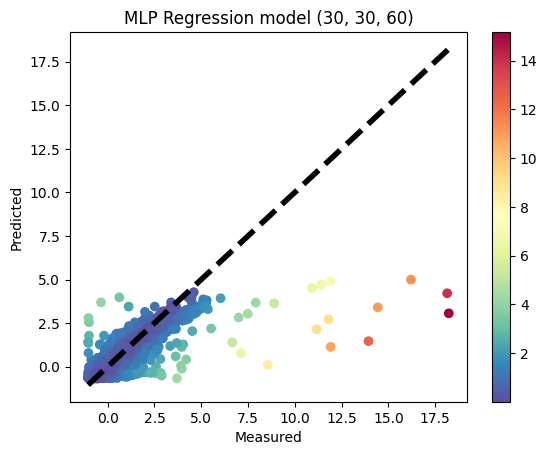

In [ ]:

# Split the data into train and test sets with random_state=42
X_train, X_test, y_train, y_test = train_test_split(X_gt_S, Y_gt_S, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

# Train the MLP model with specified architecture, activation function, and weight decay
mlp = MLPRegressor(hidden_layer_sizes=(30, 30, 60), activation='relu', alpha=10)
mlp.fit(X_train, y_train)

# Generate predictions for the test set
y_pred = mlp.predict(X_test)

# Calculate absolute difference between predicted and actual values
diff = np.abs(y_test - y_pred)
# Calculate MSE, MAE, and R2-score
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R2-score:", r2)
# Plot predicted vs. actual values with color variation based on prediction accuracy
fig, ax = plt.subplots()
scatter = ax.scatter(y_test, y_pred, c=diff, cmap='Spectral_r')
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.title("MLP Regression model (30, 30, 60)")
plt.colorbar(scatter)
plt.show()


In [ ]:
pipeline = Pipeline([
    ('standardize', StandardScaler()),
    ('kbest', SelectKBest(k = 9, score_func = mutual_info_regression)),
    ('model', RandomForestRegressor(random_state = 42, oob_score = True))
])
                         
param_grid = {
    'model__max_features': np.arange(1, 10, 1),
    'model__n_estimators': np.arange(10, 50, 10),
    'model__max_depth': np.arange(1, 7, 1)
}

grid = GridSearchCV(pipeline, param_grid = param_grid, cv = 10, n_jobs = -1, verbose = 3, 
                     scoring = 'neg_root_mean_squared_error', return_train_score = True).fit(X_gt_S, Y_gt_S)

Fitting 10 folds for each of 216 candidates, totalling 2160 fits


/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees wer

/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees wer

/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees wer

/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees wer

/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees wer

/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees wer

/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees wer

/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees wer

/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees wer

/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees wer

/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees wer

/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees wer

/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees wer

/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees wer

/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees wer

/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees wer

/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees wer

/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees wer

/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees wer

/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees wer

/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees wer

/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees wer

/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees wer

[CV 8/10] END model__max_depth=1, model__max_features=1, model__n_estimators=10;, score=(train=-0.806, test=-0.836) total time=   4.0s
[CV 3/10] END model__max_depth=1, model__max_features=1, model__n_estimators=20;, score=(train=-0.785, test=-1.048) total time=   4.0s
[CV 1/10] END model__max_depth=1, model__max_features=1, model__n_estimators=30;, score=(train=-0.841, test=-0.593) total time=   3.8s
[CV 7/10] END model__max_depth=1, model__max_features=1, model__n_estimators=30;, score=(train=-0.842, test=-0.693) total time=   4.2s
[CV 5/10] END model__max_depth=1, model__max_features=1, model__n_estimators=40;, score=(train=-0.827, test=-1.008) total time=   4.3s
[CV 2/10] END model__max_depth=1, model__max_features=2, model__n_estimators=10;, score=(train=-0.765, test=-0.932) total time=   4.2s
[CV 1/10] END model__max_depth=1, model__max_features=2, model__n_estimators=20;, score=(train=-0.797, test=-0.573) total time=   4.2s
[CV 8/10] END model__max_depth=1, model__max_features=2

/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees wer

[CV 7/10] END model__max_depth=1, model__max_features=1, model__n_estimators=10;, score=(train=-0.829, test=-0.676) total time=   3.9s
[CV 10/10] END model__max_depth=1, model__max_features=1, model__n_estimators=10;, score=(train=-0.820, test=-0.778) total time=   3.9s
[CV 7/10] END model__max_depth=1, model__max_features=1, model__n_estimators=20;, score=(train=-0.828, test=-0.677) total time=   3.9s
[CV 6/10] END model__max_depth=1, model__max_features=1, model__n_estimators=30;, score=(train=-0.837, test=-0.704) total time=   4.2s
[CV 4/10] END model__max_depth=1, model__max_features=1, model__n_estimators=40;, score=(train=-0.833, test=-0.828) total time=   4.3s
[CV 3/10] END model__max_depth=1, model__max_features=2, model__n_estimators=10;, score=(train=-0.768, test=-1.032) total time=   4.1s
[CV 10/10] END model__max_depth=1, model__max_features=2, model__n_estimators=10;, score=(train=-0.800, test=-0.764) total time=   4.2s
[CV 7/10] END model__max_depth=1, model__max_features

/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


[CV 1/10] END model__max_depth=1, model__max_features=1, model__n_estimators=10;, score=(train=-0.859, test=-0.598) total time=   3.8s
[CV 9/10] END model__max_depth=1, model__max_features=1, model__n_estimators=10;, score=(train=-0.807, test=-0.929) total time=   4.0s
[CV 8/10] END model__max_depth=1, model__max_features=1, model__n_estimators=20;, score=(train=-0.806, test=-0.832) total time=   3.8s
[CV 5/10] END model__max_depth=1, model__max_features=1, model__n_estimators=30;, score=(train=-0.821, test=-0.995) total time=   4.1s
[CV 3/10] END model__max_depth=1, model__max_features=1, model__n_estimators=40;, score=(train=-0.802, test=-1.079) total time=   4.3s
[CV 1/10] END model__max_depth=1, model__max_features=2, model__n_estimators=10;, score=(train=-0.799, test=-0.580) total time=   4.0s
[CV 9/10] END model__max_depth=1, model__max_features=2, model__n_estimators=10;, score=(train=-0.787, test=-0.918) total time=   4.3s
[CV 6/10] END model__max_depth=1, model__max_features=2

/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


[CV 4/10] END model__max_depth=1, model__max_features=1, model__n_estimators=10;, score=(train=-0.818, test=-0.790) total time=   4.0s
[CV 4/10] END model__max_depth=1, model__max_features=1, model__n_estimators=20;, score=(train=-0.816, test=-0.793) total time=   4.0s
[CV 9/10] END model__max_depth=1, model__max_features=1, model__n_estimators=20;, score=(train=-0.805, test=-0.927) total time=   4.1s
[CV 9/10] END model__max_depth=1, model__max_features=1, model__n_estimators=30;, score=(train=-0.819, test=-0.937) total time=   4.4s
[CV 8/10] END model__max_depth=1, model__max_features=1, model__n_estimators=40;, score=(train=-0.823, test=-0.857) total time=   4.3s
[CV 5/10] END model__max_depth=1, model__max_features=2, model__n_estimators=10;, score=(train=-0.791, test=-0.938) total time=   4.2s
[CV 3/10] END model__max_depth=1, model__max_features=2, model__n_estimators=20;, score=(train=-0.753, test=-1.024) total time=   4.4s
[CV 1/10] END model__max_depth=1, model__max_features=2

[CV 5/10] END model__max_depth=1, model__max_features=1, model__n_estimators=10;, score=(train=-0.809, test=-0.973) total time=   4.0s
[CV 2/10] END model__max_depth=1, model__max_features=1, model__n_estimators=20;, score=(train=-0.814, test=-0.948) total time=   4.1s
[CV 2/10] END model__max_depth=1, model__max_features=1, model__n_estimators=30;, score=(train=-0.803, test=-0.941) total time=   4.0s
[CV 10/10] END model__max_depth=1, model__max_features=1, model__n_estimators=30;, score=(train=-0.832, test=-0.788) total time=   4.3s
[CV 7/10] END model__max_depth=1, model__max_features=1, model__n_estimators=40;, score=(train=-0.848, test=-0.699) total time=   4.5s
[CV 6/10] END model__max_depth=1, model__max_features=2, model__n_estimators=10;, score=(train=-0.806, test=-0.665) total time=   4.4s
[CV 5/10] END model__max_depth=1, model__max_features=2, model__n_estimators=20;, score=(train=-0.783, test=-0.906) total time=   4.4s
[CV 3/10] END model__max_depth=1, model__max_features=

[CV 6/10] END model__max_depth=1, model__max_features=1, model__n_estimators=10;, score=(train=-0.825, test=-0.688) total time=   4.0s
[CV 1/10] END model__max_depth=1, model__max_features=1, model__n_estimators=20;, score=(train=-0.853, test=-0.597) total time=   4.0s
[CV 10/10] END model__max_depth=1, model__max_features=1, model__n_estimators=20;, score=(train=-0.818, test=-0.774) total time=   3.9s
[CV 8/10] END model__max_depth=1, model__max_features=1, model__n_estimators=30;, score=(train=-0.818, test=-0.848) total time=   4.3s
[CV 6/10] END model__max_depth=1, model__max_features=1, model__n_estimators=40;, score=(train=-0.843, test=-0.718) total time=   4.2s
[CV 4/10] END model__max_depth=1, model__max_features=2, model__n_estimators=10;, score=(train=-0.799, test=-0.764) total time=   4.3s
[CV 2/10] END model__max_depth=1, model__max_features=2, model__n_estimators=20;, score=(train=-0.771, test=-0.904) total time=   4.3s
[CV 10/10] END model__max_depth=1, model__max_features

/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees wer

[CV 2/10] END model__max_depth=1, model__max_features=1, model__n_estimators=10;, score=(train=-0.803, test=-0.910) total time=   4.1s
[CV 5/10] END model__max_depth=1, model__max_features=1, model__n_estimators=20;, score=(train=-0.808, test=-0.970) total time=   4.1s
[CV 3/10] END model__max_depth=1, model__max_features=1, model__n_estimators=30;, score=(train=-0.797, test=-1.066) total time=   3.9s
[CV 1/10] END model__max_depth=1, model__max_features=1, model__n_estimators=40;, score=(train=-0.862, test=-0.611) total time=   4.3s
[CV 9/10] END model__max_depth=1, model__max_features=1, model__n_estimators=40;, score=(train=-0.827, test=-0.925) total time=   4.4s
[CV 7/10] END model__max_depth=1, model__max_features=2, model__n_estimators=10;, score=(train=-0.811, test=-0.658) total time=   4.2s
[CV 4/10] END model__max_depth=1, model__max_features=2, model__n_estimators=20;, score=(train=-0.784, test=-0.766) total time=   4.5s
[CV 2/10] END model__max_depth=1, model__max_features=2

/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees wer

/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees wer

/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees wer

[CV 3/10] END model__max_depth=1, model__max_features=1, model__n_estimators=10;, score=(train=-0.787, test=-1.052) total time=   4.7s
[CV 6/10] END model__max_depth=1, model__max_features=1, model__n_estimators=20;, score=(train=-0.823, test=-0.691) total time=   4.5s
[CV 4/10] END model__max_depth=1, model__max_features=1, model__n_estimators=30;, score=(train=-0.829, test=-0.810) total time=   4.7s
[CV 2/10] END model__max_depth=1, model__max_features=1, model__n_estimators=40;, score=(train=-0.821, test=-0.925) total time=   4.9s
[CV 10/10] END model__max_depth=1, model__max_features=1, model__n_estimators=40;, score=(train=-0.839, test=-0.786) total time=   4.9s
[CV 8/10] END model__max_depth=1, model__max_features=2, model__n_estimators=10;, score=(train=-0.786, test=-0.829) total time=   5.0s
[CV 9/10] END model__max_depth=1, model__max_features=2, model__n_estimators=20;, score=(train=-0.775, test=-0.890) total time=   5.3s
[CV 8/10] END model__max_depth=1, model__max_features=

/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees wer

/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees wer

/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees wer

/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees wer

/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees wer

/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees wer

/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees wer

/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees wer

/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madhavsankar/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:833: UserWarning: Some inputs do not have OOB scores. This probably means too few trees wer

In [ ]:
result = pd.DataFrame(grid.cv_results_)[['mean_test_score', 'mean_train_score', 'param_model__max_features', 'param_model__n_estimators', 'param_model__max_depth']]
result = result.sort_values(by=['mean_test_score'], ascending = False).reset_index(drop = True)
result.to_csv('gtRF.csv', sep='\t', encoding='utf-8')
print(result.head())
print('Best parameters:',grid.best_params_,',Test RMSE:',grid.best_score_)
print('Train RMSE:',max(result.mean_train_score))


   mean_test_score  mean_train_score param_model__max_features  \
0        -0.580643         -0.458101                         4   
1        -0.582024         -0.459547                         4   
2        -0.583045         -0.455967                         5   
3        -0.583428         -0.458749                         4   
4        -0.584657         -0.489195                         5   

  param_model__n_estimators param_model__max_depth  
0                        40                      6  
1                        20                      6  
2                        40                      6  
3                        30                      6  
4                        20                      5  
Best parameters: {'model__max_depth': 6, 'model__max_features': 4, 'model__n_estimators': 40} ,Test RMSE: -0.5806434107682812
Train RMSE: -0.45439940041337373


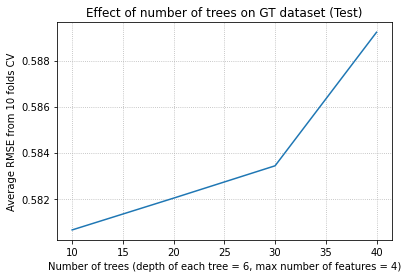

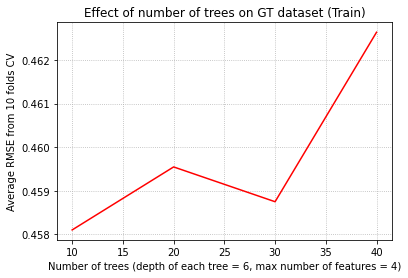

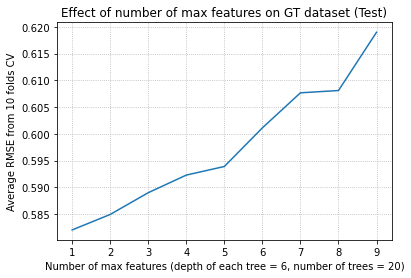

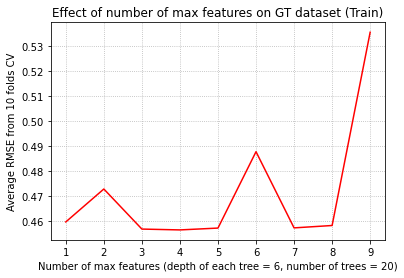

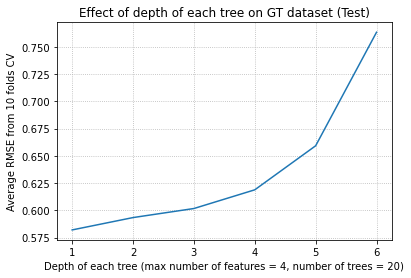

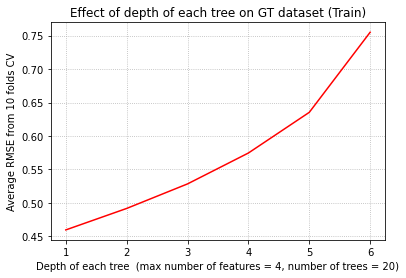

[CV 4/10] END model__max_depth=3, model__max_features=6, model__n_estimators=40;, score=(train=-0.565, test=-0.628) total time=   7.2s
[CV 2/10] END model__max_depth=3, model__max_features=7, model__n_estimators=10;, score=(train=-0.562, test=-0.735) total time=   5.9s
[CV 10/10] END model__max_depth=3, model__max_features=7, model__n_estimators=10;, score=(train=-0.577, test=-0.535) total time=   5.8s
[CV 7/10] END model__max_depth=3, model__max_features=7, model__n_estimators=20;, score=(train=-0.581, test=-0.512) total time=   6.3s
[CV 5/10] END model__max_depth=3, model__max_features=7, model__n_estimators=30;, score=(train=-0.575, test=-0.536) total time=   6.8s
[CV 3/10] END model__max_depth=3, model__max_features=7, model__n_estimators=40;, score=(train=-0.544, test=-0.817) total time=   7.4s
[CV 1/10] END model__max_depth=3, model__max_features=8, model__n_estimators=10;, score=(train=-0.593, test=-0.452) total time=   5.9s
[CV 8/10] END model__max_depth=3, model__max_features=

[CV 2/10] END model__max_depth=3, model__max_features=6, model__n_estimators=30;, score=(train=-0.556, test=-0.725) total time=   6.9s
[CV 9/10] END model__max_depth=3, model__max_features=6, model__n_estimators=30;, score=(train=-0.557, test=-0.697) total time=   6.9s
[CV 7/10] END model__max_depth=3, model__max_features=6, model__n_estimators=40;, score=(train=-0.575, test=-0.515) total time=   6.9s
[CV 5/10] END model__max_depth=3, model__max_features=7, model__n_estimators=10;, score=(train=-0.580, test=-0.526) total time=   5.7s
[CV 3/10] END model__max_depth=3, model__max_features=7, model__n_estimators=20;, score=(train=-0.544, test=-0.825) total time=   6.3s
[CV 1/10] END model__max_depth=3, model__max_features=7, model__n_estimators=30;, score=(train=-0.586, test=-0.455) total time=   6.9s
[CV 9/10] END model__max_depth=3, model__max_features=7, model__n_estimators=30;, score=(train=-0.560, test=-0.696) total time=   6.9s
[CV 7/10] END model__max_depth=3, model__max_features=7

[CV 6/10] END model__max_depth=3, model__max_features=9, model__n_estimators=40;, score=(train=-0.577, test=-0.627) total time=   8.5s
[CV 4/10] END model__max_depth=4, model__max_features=1, model__n_estimators=10;, score=(train=-0.612, test=-0.668) total time=   6.5s
[CV 2/10] END model__max_depth=4, model__max_features=1, model__n_estimators=20;, score=(train=-0.602, test=-0.715) total time=   6.8s
[CV 2/10] END model__max_depth=4, model__max_features=1, model__n_estimators=30;, score=(train=-0.619, test=-0.731) total time=   6.8s
[CV 2/10] END model__max_depth=4, model__max_features=1, model__n_estimators=40;, score=(train=-0.612, test=-0.780) total time=   6.9s
[CV 2/10] END model__max_depth=4, model__max_features=2, model__n_estimators=10;, score=(train=-0.551, test=-0.653) total time=   6.6s
[CV 10/10] END model__max_depth=4, model__max_features=2, model__n_estimators=10;, score=(train=-0.572, test=-0.527) total time=   6.6s
[CV 9/10] END model__max_depth=4, model__max_features=

[CV 7/10] END model__max_depth=3, model__max_features=6, model__n_estimators=30;, score=(train=-0.576, test=-0.507) total time=   6.7s
[CV 5/10] END model__max_depth=3, model__max_features=6, model__n_estimators=40;, score=(train=-0.573, test=-0.558) total time=   7.0s
[CV 3/10] END model__max_depth=3, model__max_features=7, model__n_estimators=10;, score=(train=-0.546, test=-0.837) total time=   5.9s
[CV 1/10] END model__max_depth=3, model__max_features=7, model__n_estimators=20;, score=(train=-0.590, test=-0.457) total time=   6.4s
[CV 9/10] END model__max_depth=3, model__max_features=7, model__n_estimators=20;, score=(train=-0.560, test=-0.695) total time=   6.6s
[CV 8/10] END model__max_depth=3, model__max_features=7, model__n_estimators=30;, score=(train=-0.577, test=-0.581) total time=   6.8s
[CV 5/10] END model__max_depth=3, model__max_features=7, model__n_estimators=40;, score=(train=-0.575, test=-0.544) total time=   7.2s
[CV 3/10] END model__max_depth=3, model__max_features=8

[CV 4/10] END model__max_depth=3, model__max_features=6, model__n_estimators=30;, score=(train=-0.566, test=-0.629) total time=   6.9s
[CV 2/10] END model__max_depth=3, model__max_features=6, model__n_estimators=40;, score=(train=-0.558, test=-0.724) total time=   7.1s
[CV 10/10] END model__max_depth=3, model__max_features=6, model__n_estimators=40;, score=(train=-0.573, test=-0.527) total time=   6.9s
[CV 7/10] END model__max_depth=3, model__max_features=7, model__n_estimators=10;, score=(train=-0.583, test=-0.514) total time=   5.7s
[CV 5/10] END model__max_depth=3, model__max_features=7, model__n_estimators=20;, score=(train=-0.577, test=-0.537) total time=   6.4s
[CV 3/10] END model__max_depth=3, model__max_features=7, model__n_estimators=30;, score=(train=-0.544, test=-0.822) total time=   6.7s
[CV 1/10] END model__max_depth=3, model__max_features=7, model__n_estimators=40;, score=(train=-0.587, test=-0.455) total time=   7.4s
[CV 9/10] END model__max_depth=3, model__max_features=

[CV 10/10] END model__max_depth=3, model__max_features=6, model__n_estimators=20;, score=(train=-0.573, test=-0.531) total time=   6.2s
[CV 8/10] END model__max_depth=3, model__max_features=6, model__n_estimators=30;, score=(train=-0.572, test=-0.573) total time=   6.7s
[CV 6/10] END model__max_depth=3, model__max_features=6, model__n_estimators=40;, score=(train=-0.565, test=-0.602) total time=   7.0s
[CV 4/10] END model__max_depth=3, model__max_features=7, model__n_estimators=10;, score=(train=-0.576, test=-0.633) total time=   5.8s
[CV 2/10] END model__max_depth=3, model__max_features=7, model__n_estimators=20;, score=(train=-0.558, test=-0.724) total time=   6.3s
[CV 10/10] END model__max_depth=3, model__max_features=7, model__n_estimators=20;, score=(train=-0.576, test=-0.528) total time=   6.1s
[CV 6/10] END model__max_depth=3, model__max_features=7, model__n_estimators=30;, score=(train=-0.569, test=-0.613) total time=   6.7s
[CV 4/10] END model__max_depth=3, model__max_features

In [ ]:
max_features = np.arange(1, 10, 1).reshape(9)
n_estimators = np.arange(10, 50, 10).reshape(4)
max_depth = np.arange(1, 7, 1).reshape(6)

score = np.negative(list((result[(result['param_model__max_depth'] == 6) & (result['param_model__max_features'] == 4)]).mean_test_score))
train = np.negative(list((result[(result['param_model__max_depth'] == 6) & (result['param_model__max_features'] == 4)]).mean_train_score))
plt.plot(n_estimators, score)
plt.grid(linestyle=':')
plt.xlabel('Number of trees (depth of each tree = 6, max number of features = 4)')
plt.ylabel('Average RMSE from 10 folds CV')
plt.title('Effect of number of trees on GT dataset (Test)')
plt.show()

plt.plot(n_estimators, train, 'r')
plt.grid(linestyle=':')
plt.xlabel('Number of trees (depth of each tree = 6, max number of features = 4)')
plt.ylabel('Average RMSE from 10 folds CV')
plt.title('Effect of number of trees on GT dataset (Train)')
plt.show()

score = np.negative(list((result[(result['param_model__max_depth'] == 6) & (result['param_model__n_estimators'] == 20)]).mean_test_score))
train = np.negative(list((result[(result['param_model__max_depth'] == 6) & (result['param_model__n_estimators'] == 20)]).mean_train_score))
plt.plot(max_features, score)
plt.grid(linestyle=':')
plt.xlabel('Number of max features (depth of each tree = 6, number of trees = 20)')
plt.ylabel('Average RMSE from 10 folds CV')
plt.title('Effect of number of max features on GT dataset (Test)')
plt.show()

plt.plot(max_features, train, 'r')
plt.grid(linestyle=':')
plt.xlabel('Number of max features (depth of each tree = 6, number of trees = 20)')
plt.ylabel('Average RMSE from 10 folds CV')
plt.title('Effect of number of max features on GT dataset (Train)')
plt.show()

score = np.negative(list((result[(result['param_model__max_features'] == 4) & (result['param_model__n_estimators'] == 20)]).mean_test_score))
train = np.negative(list((result[(result['param_model__max_features'] == 4) & (result['param_model__n_estimators'] == 20)]).mean_train_score))
plt.plot(max_depth, score)
plt.grid(linestyle=':')
plt.xlabel('Depth of each tree (max number of features = 4, number of trees = 20)')
plt.ylabel('Average RMSE from 10 folds CV')
plt.title('Effect of depth of each tree on GT dataset (Test)')
plt.show()

plt.plot(max_depth, train, 'r')
plt.grid(linestyle=':')
plt.xlabel('Depth of each tree  (max number of features = 4, number of trees = 20)')
plt.ylabel('Average RMSE from 10 folds CV')
plt.title('Effect of depth of each tree on GT dataset (Train)')
plt.show()

In [ ]:
print('OOB, GT:',RandomForestRegressor(random_state=42,max_depth=6,
                                         max_features=5, n_estimators=40, oob_score=True).fit(X_gt_S, Y_gt_S).oob_score_)

OOB, GT: 0.7220917422471709


10
20
30
40


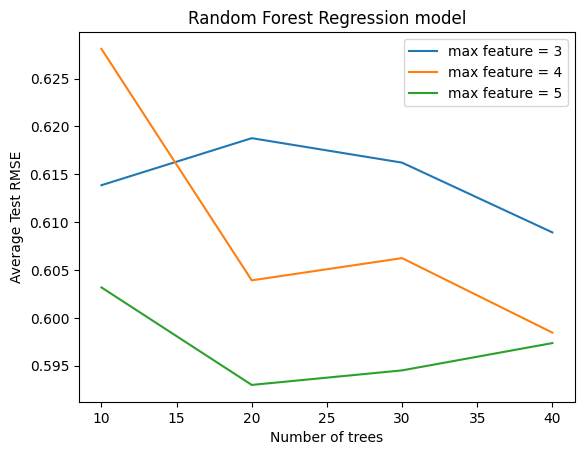

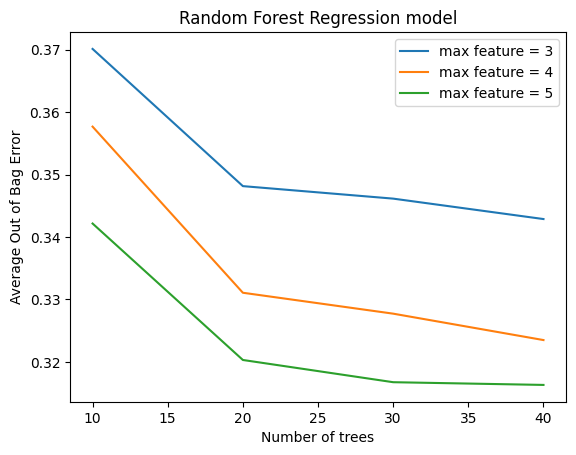

1
2
3
4
5
6
7
8
9


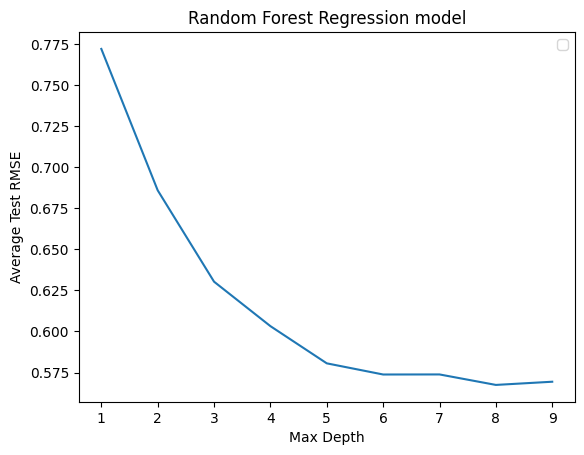

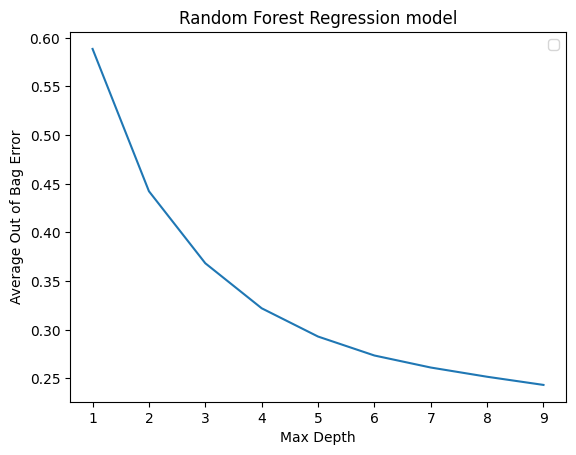

1
2
3
4
5
6
7
8


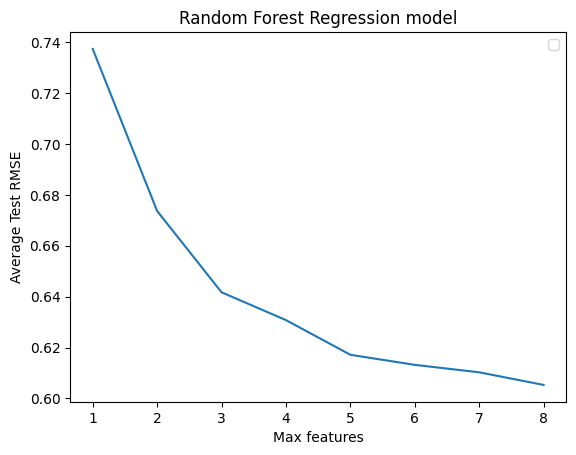

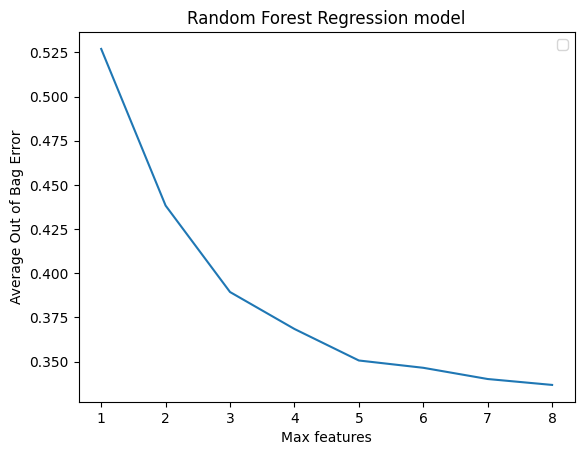

[0.4072224  0.60980867 0.78677779 0.58607841 0.56116346 0.59045115
 0.57637778 0.4960415  0.61164972 0.5577603 ]
Feature importances from best random forest model: 
 [0.04157426 0.02375536 0.02340953 0.04736762 0.13014561 0.31232198
 0.16125815 0.09250422 0.10959249 0.018539   0.00590408 0.00256483
 0.00745831 0.02360457]


In [ ]:
import warnings
warnings.filterwarnings("ignore")

X = X_gt_S
y = Y_gt_S
trees = np.arange(10, 50, 10)
oob3 = []; oob4 = []; oob5 = [];
test_rmse3 = []; test_rmse4 = []; test_rmse5 = [];
for i in trees:
    print(i)
    rf = RandomForestRegressor(n_estimators=i,max_depth=4,bootstrap=True,max_features=3,oob_score=True,warm_start=True)
    cv_results = cross_validate(rf,X,y,scoring='neg_mean_squared_error',cv=10,return_train_score=True,return_estimator=True)
    test_rmse3.append( np.mean(np.sqrt(cv_results['test_score']*(-1.))) )
    oob3.append( 1-np.mean([i.oob_score_ for i in cv_results['estimator']]) )
    
    rf = RandomForestRegressor(n_estimators=i,max_depth=4,bootstrap=True,max_features=4,oob_score=True,warm_start=True)
    cv_results = cross_validate(rf,X,y,scoring='neg_mean_squared_error',cv=10,return_train_score=True,return_estimator=True)
    test_rmse4.append( np.mean(np.sqrt(cv_results['test_score']*(-1.))) )
    oob4.append( 1-np.mean([i.oob_score_ for i in cv_results['estimator']]) )
    
    rf = RandomForestRegressor(n_estimators=i,max_depth=4,bootstrap=True,max_features=5,oob_score=True,warm_start=True)
    cv_results = cross_validate(rf,X,y,scoring='neg_mean_squared_error',cv=10,return_train_score=True,return_estimator=True)
    test_rmse5.append( np.mean(np.sqrt(cv_results['test_score']*(-1.))) )
    oob5.append( 1-np.mean([i.oob_score_ for i in cv_results['estimator']]) )

fig, ax = plt.subplots()
ax.plot(trees,test_rmse3, label='max feature = 3')
ax.plot(trees,test_rmse4, label='max feature = 4')
ax.plot(trees,test_rmse5, label='max feature = 5')
ax.legend(loc='best')
plt.xlabel("Number of trees")
plt.ylabel("Average Test RMSE")
plt.title("Random Forest Regression model")
plt.show()

fig, ax = plt.subplots()
ax.plot(trees,oob3, label='max feature = 3')
ax.plot(trees,oob4, label='max feature = 4')
ax.plot(trees,oob5, label='max feature = 5')
ax.legend(loc='best')
plt.xlabel("Number of trees")
plt.ylabel("Average Out of Bag Error")
plt.title("Random Forest Regression model")
plt.show()

depth = np.arange(1, 10, 1)
test_rmse = []
oob = []
for i in depth:
    print(i)
    rf = RandomForestRegressor(n_estimators=50,max_features=4,max_depth=i,bootstrap=True,oob_score=True,warm_start=True)
    cv_results = cross_validate(rf,X,y,scoring='neg_mean_squared_error',cv=10,return_train_score=True,return_estimator=True)
    test_rmse.append( np.mean(np.sqrt(cv_results['test_score']*(-1.))) )
    oob.append( 1-np.mean([i.oob_score_ for i in cv_results['estimator']]) )

fig, ax = plt.subplots()
ax.plot(depth,test_rmse)
ax.legend(loc='best')
plt.xlabel("Max Depth"); plt.ylabel("Average Test RMSE"); plt.title("Random Forest Regression model")
plt.show()

fig, ax = plt.subplots()
ax.plot(depth,oob)
ax.legend(loc='best')
plt.xlabel("Max Depth"); plt.ylabel("Average Out of Bag Error"); plt.title("Random Forest Regression model")
plt.show()

features = np.arange(1, 9, 1)
test_rmse = []
oob = []
for i in features:
    print(i)
    rf = RandomForestRegressor(n_estimators=50,max_features=i,max_depth=3,bootstrap=True,oob_score=True,warm_start=True)
    cv_results = cross_validate(rf,X,y,scoring='neg_mean_squared_error',cv=10,return_train_score=True,return_estimator=True)
    test_rmse.append( np.mean(np.sqrt(cv_results['test_score']*(-1.))) )
    oob.append( 1-np.mean([i.oob_score_ for i in cv_results['estimator']]) )

fig, ax = plt.subplots()
ax.plot(features,test_rmse)
ax.legend(loc='best')
plt.xlabel("Max features"); plt.ylabel("Average Test RMSE"); plt.title("Random Forest Regression model")
plt.show()

fig, ax = plt.subplots()
ax.plot(features,oob)
ax.legend(loc='best')
plt.xlabel("Max features"); plt.ylabel("Average Out of Bag Error"); plt.title("Random Forest Regression model")
plt.show()

rf = RandomForestRegressor(n_estimators=20,max_features=4,max_depth=10,bootstrap=True,oob_score=True,warm_start=True)
cv_results = cross_validate(rf,X,y,scoring='neg_mean_squared_error',cv=10,return_train_score=True,return_estimator=True)
print( np.sqrt(cv_results['test_score']*(-1.)) )
print("Feature importances from best random forest model: \n", cv_results['estimator'][4].feature_importances_)


Mean Squared Error (MSE): 0.20940858397115023
Root Mean Squared Error (RMSE): 0.45761182673872214
Mean Absolute Error (MAE): 0.24411715528999844
R2-score: 0.8028414934855937


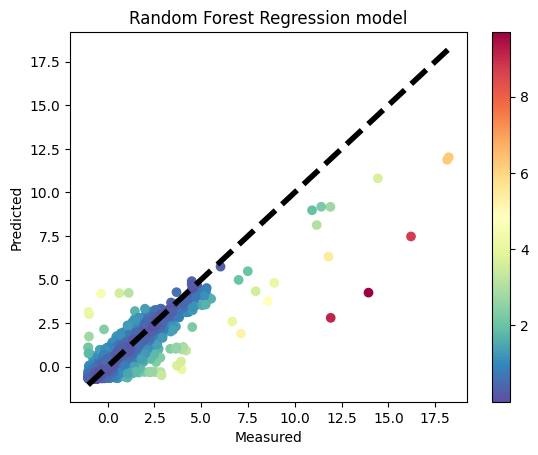

In [ ]:

# Train the best random forest model
rf = RandomForestRegressor(n_estimators=50,max_features=4,max_depth=6,bootstrap=True,oob_score=True,warm_start=True)
rf.fit(X_gt_S, Y_gt_S)

# Generate predictions for the test set
y_pred = rf.predict(X_test)

# Calculate absolute difference between predicted and actual values
diff = np.abs(y_test - y_pred)
# Calculate MSE, RMSE, MAE, and R2-score
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("R2-score:", r2)
# Plot predicted vs. actual values with color variation based on prediction accuracy
fig, ax = plt.subplots()
scatter = ax.scatter(y_test, y_pred, c=diff, cmap='Spectral_r')
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.title("Random Forest Regression model")
plt.colorbar(scatter)
plt.show()


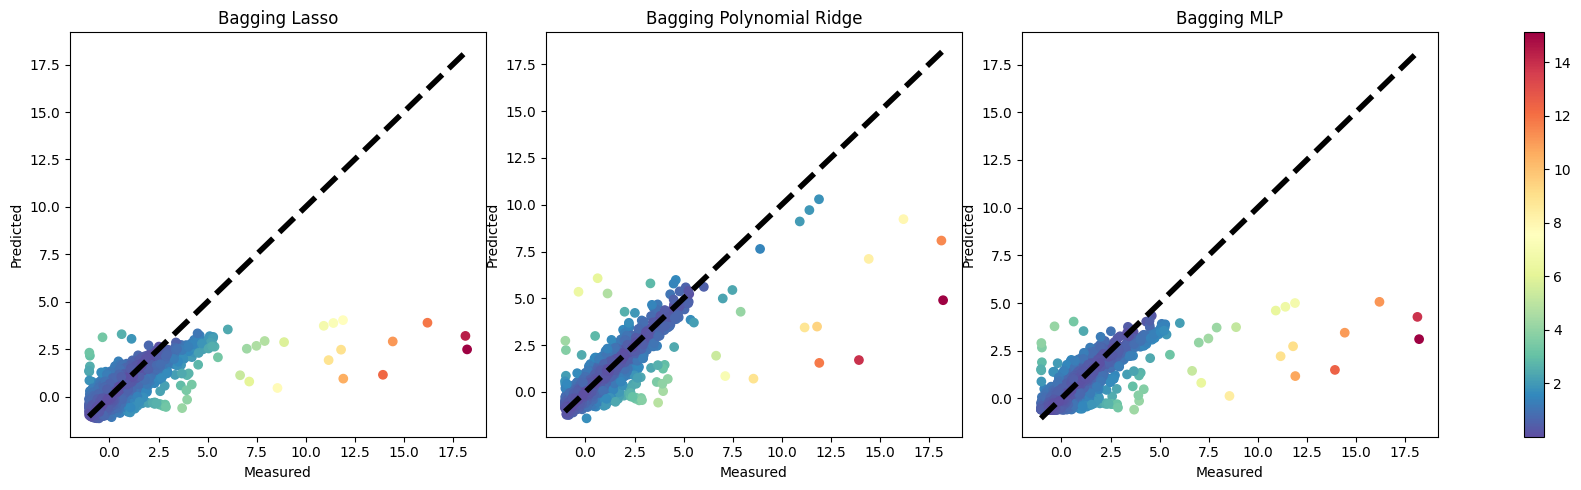

In [ ]:

# Split the data into train and test sets with random_state=42
X_train, X_test, y_train, y_test = train_test_split(X_gt_S, Y_gt_S, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

# Create polynomial features with degree=2
poly_features = PolynomialFeatures(degree=2)
X_train_poly = poly_features.fit_transform(X_train_std)
X_test_poly = poly_features.transform(X_test_std)

# Create the base regressors
lasso = Lasso(alpha=0.01)
poly_ridge = Ridge(alpha=0.1)
mlp = MLPRegressor(hidden_layer_sizes=(30, 30, 60), activation='relu', alpha=10)

# Create Bagging models for each regressor
bagging_lasso = BaggingRegressor(lasso)
bagging_poly_ridge = BaggingRegressor(poly_ridge)
bagging_mlp = BaggingRegressor(mlp)

# Fit the Bagging models
bagging_lasso.fit(X_train_std, y_train)
bagging_poly_ridge.fit(X_train_poly, y_train)
bagging_mlp.fit(X_train_std, y_train)

# Generate predictions for the test set
y_pred_lasso = bagging_lasso.predict(X_test_std)
y_pred_poly_ridge = bagging_poly_ridge.predict(X_test_poly)
y_pred_mlp = bagging_mlp.predict(X_test_std)

# Plot the results for each Bagging model
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, y_pred, title in zip(
    axes, 
    [y_pred_lasso, y_pred_poly_ridge, y_pred_mlp], 
    ["Bagging Lasso", "Bagging Polynomial Ridge", "Bagging MLP"]
):
    diff = np.abs(y_test - y_pred)
    scatter = ax.scatter(y_test, y_pred, c=diff, cmap='Spectral_r')
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    ax.set_title(title)

plt.tight_layout()
plt.colorbar(scatter, ax=axes.ravel().tolist())
plt.show()


Mean Squared Error (MSE): 0.3482732280197412
Mean Absolute Error (MAE): 0.27775444056829357
R2-score: 0.6721002157925708


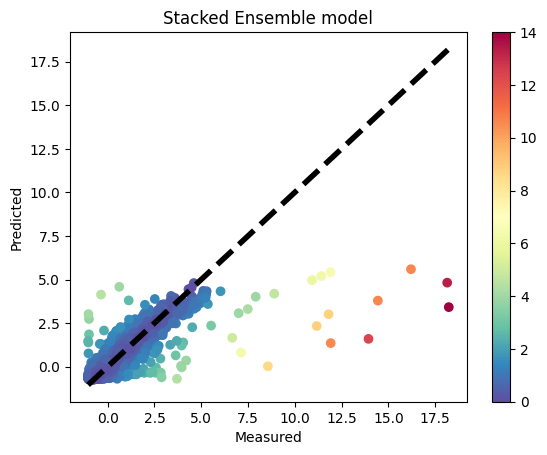

In [ ]:

# Split the data into train and test sets with random_state=42
X_train, X_test, y_train, y_test = train_test_split(X_gt_S, Y_gt_S, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

# Create polynomial features with degree=2
poly_features = PolynomialFeatures(degree=2)
X_train_poly = poly_features.fit_transform(X_train_std)
X_test_poly = poly_features.transform(X_test_std)

# Define the base models
base_models = [
    ("lasso", Lasso(alpha=0.01)),
    ("poly_ridge", Ridge(alpha=0.1)),
    ("mlp", MLPRegressor(hidden_layer_sizes=(30, 30, 60), activation="relu", alpha=10)),
]

# Create the stacked ensemble model
stacked_model = StackingRegressor(estimators=base_models, final_estimator=Ridge(alpha=1))

# Fit the stacked model
stacked_model.fit(X_train_std, y_train)

# Generate predictions for the test set
y_pred = stacked_model.predict(X_test_std)

# Calculate absolute difference between predicted and actual values
diff = np.abs(y_test - y_pred)
# Calculate MSE, MAE, and R2-score
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R2-score:", r2)
# Plot predicted vs. actual values with color variation based on prediction accuracy
fig, ax = plt.subplots()
scatter = ax.scatter(y_test, y_pred, c=diff, cmap='Spectral_r', norm=Normalize(0, 14))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.title("Stacked Ensemble model")
plt.colorbar(scatter)
plt.show()


Mean Squared Error (MSE): 0.3794966995100393
Mean Absolute Error (MAE): 0.32128029745209186
R2-score: 0.6427032689698446


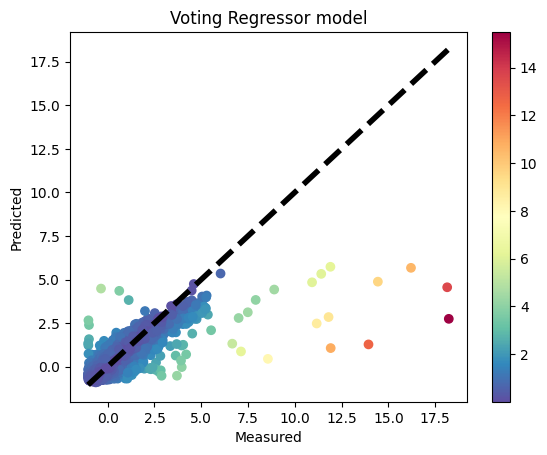

In [ ]:

# Split the data into train and test sets with random_state=42
X_train, X_test, y_train, y_test = train_test_split(X_gt_S, Y_gt_S, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

# Create polynomial features with degree=2
poly_features = PolynomialFeatures(degree=2)
X_train_poly = poly_features.fit_transform(X_train_std)
X_test_poly = poly_features.transform(X_test_std)

# Define the base models
base_models = [
    ("lasso", Lasso(alpha=0.01)),
    ("poly_ridge", Ridge(alpha=0.1)),
    ("mlp", MLPRegressor(hidden_layer_sizes=(30, 30, 60), activation="relu", alpha=10, max_iter=1000)),
]

# Create the stacked ensemble model
stacked_model = StackingRegressor(estimators=base_models, final_estimator=Ridge(alpha=1))
stacked_model.fit(X_train_std, y_train)

# Create the voting regressor with base models and stacked model
voting_model = VotingRegressor(
    estimators=[
        ("lasso", base_models[0][1]),
        ("poly_ridge", base_models[1][1]),
        ("mlp", base_models[2][1]),
        ("stacked", stacked_model),
    ]
)

# Fit the voting model
voting_model.fit(X_train_std, y_train)

# Generate predictions for the test set
y_pred = voting_model.predict(X_test_std)

# Calculate absolute difference between predicted and actual values
diff = np.abs(y_test - y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R2-score:", r2)
# Plot predicted vs. actual values with color variation based on prediction accuracy
fig, ax = plt.subplots()
scatter = ax.scatter(y_test, y_pred, c=diff, cmap='Spectral_r')
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.title("Voting Regressor model")
plt.colorbar(scatter)
plt.show()


Mean Squared Error (MSE): 0.6518066037514003
Mean Absolute Error (MAE): 0.4718695753319966
R2-score: 0.38632307188726356


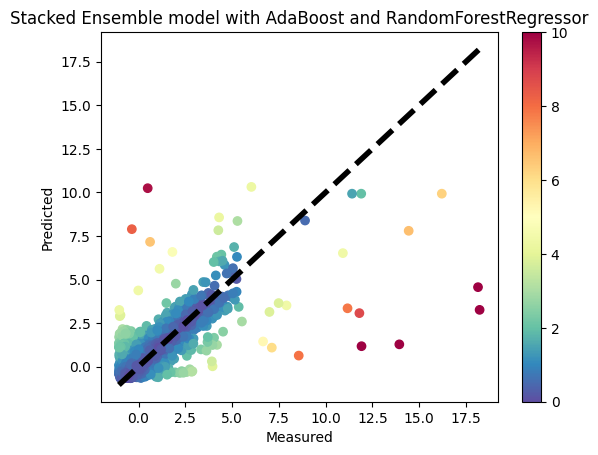

In [ ]:

# Standardize the features
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

# Create polynomial features with degree=2
poly_features = PolynomialFeatures(degree=2)
X_train_poly = poly_features.fit_transform(X_train_std)
X_test_poly = poly_features.transform(X_test_std)

# Define the base models
base_models = [
    ("lasso", Lasso(alpha=0.01)),
    ("poly_ridge", Ridge(alpha=0.1)),
    ("mlp", MLPRegressor(hidden_layer_sizes=(30, 30, 60), activation="relu", alpha=10),
    ("adaboost", AdaBoostRegressor(RandomForestRegressor(n_estimators=50, max_features=4, max_depth=10)),
    
]

# Create the stacked ensemble model
stacked_model = StackingRegressor(estimators=base_models, final_estimator=RandomForestRegressor(n_estimators=40, max_features=4, max_depth=6), n_estimators=50))

# Fit the stacked model
stacked_model.fit(X_train_std, y_train)

# Generate predictions for the test set
y_pred = stacked_model.predict(X_test_std)

# Calculate absolute difference between predicted and actual values
diff = np.abs(y_test - y_pred)
# Calculate MSE, MAE, and R2-score
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R2-score:", r2)
# Plot predicted vs. actual values with color variation based on prediction accuracy
fig, ax = plt.subplots()
scatter = ax.scatter(y_test, y_pred, c=diff, cmap='Spectral_r', norm=Normalize(0, 10))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.title("Stacked Ensemble model with AdaBoost and RandomForestRegressor")
plt.colorbar(scatter)
plt.show()


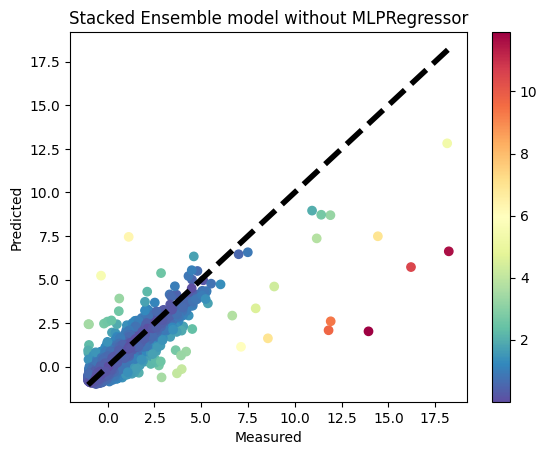

In [ ]:

# Split the data into train and test sets with random_state=42
X_train, X_test, y_train, y_test = train_test_split(X_gt_S, Y_gt_S, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

# Create polynomial features with degree=2
poly_features = PolynomialFeatures(degree=2)
X_train_poly = poly_features.fit_transform(X_train_std)
X_test_poly = poly_features.transform(X_test_std)

# Define the base models
base_models = [
    ("lasso", Lasso(alpha=0.01)),
    ("poly_ridge", Ridge(alpha=0.1)),
    ("adaboost", AdaBoostRegressor(RandomForestRegressor(n_estimators=40, max_features=4, max_depth=8), n_estimators=50))
]

# Create the stacked ensemble model
stacked_model = StackingRegressor(estimators=base_models, final_estimator=Ridge(alpha=1))

# Fit the stacked model
stacked_model.fit(X_train_std, y_train)

# Generate predictions for the test set
y_pred = stacked_model.predict(X_test_std)

# Calculate absolute difference between predicted and actual values
diff = np.abs(y_test - y_pred)

# Plot predicted vs. actual values with color variation based on prediction accuracy
fig, ax = plt.subplots()
scatter = ax.scatter(y_test, y_pred, c=diff, cmap='Spectral_r', norm=Normalize(0, 10))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.title("Stacked Ensemble model without MLPRegressor")
plt.colorbar(scatter)
plt.show()


<function matplotlib.pyplot.title(label, fontdict=None, loc=None, pad=None, *, y=None, **kwargs)>

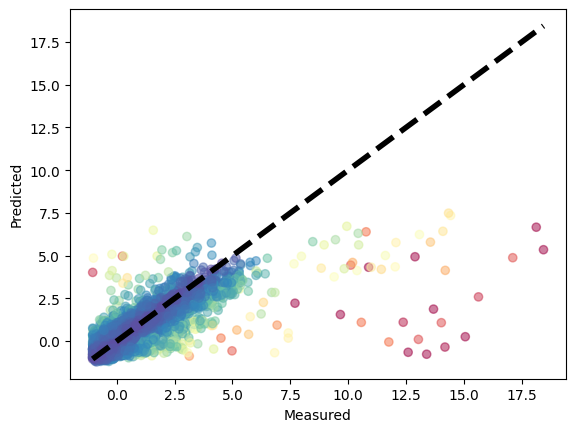

In [ ]:
from sklearn.model_selection import KFold

# Define the base models
base_models = [
    ("lasso", Lasso(alpha=0.01)),
    ("poly_ridge", Ridge(alpha=0.1)),
    ("adaboost", AdaBoostRegressor(RandomForestRegressor(n_estimators=40, max_features=4, max_depth=6), n_estimators=50))
]

# Create the stacked ensemble model
stacked_model = StackingRegressor(estimators=base_models, final_estimator=Ridge(alpha=1))

# Initialize 10-fold cross-validation
kf = KFold(n_splits=10)

fig, ax = plt.subplots()
y_true_all = []
y_pred_all = []

# Perform 10-fold cross-validation and plot the predictions
for train_index, test_index in kf.split(X_train_std):
    X_train_cv, X_test_cv = X_train_std[train_index], X_train_std[test_index]
    y_train_cv, y_test_cv = y_train.iloc[train_index], y_train.iloc[test_index]
    
    stacked_model.fit(X_train_cv, y_train_cv)
    y_pred_cv = stacked_model.predict(X_test_cv)
    
    y_true_all.extend(y_test_cv)
    y_pred_all.extend(y_pred_cv)
    
    diff_cv = np.abs(y_test_cv - y_pred_cv)
    scatter = ax.scatter(y_test_cv, y_pred_cv, c=diff_cv, cmap='Spectral_r', alpha=0.5)

# Plot the predicted vs. actual values with color variation based on prediction accuracy
ax.plot([min(y_true_all), max(y_true_all)], [min(y_true_all), max(y_true_all)], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.title


Mean Squared Error (MSE): 0.14002215271020302
Mean Absolute Error (MAE): 0.3138831338960681
R2-score: 0.8681689261072552


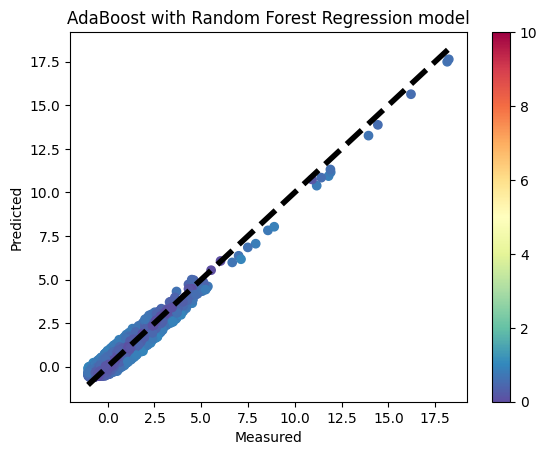

In [ ]:

# Train the random forest model
rf = RandomForestRegressor(n_estimators=50, max_features=4, max_depth=10, bootstrap=True, oob_score=True, warm_start=True)

# Create the AdaBoost model with the random forest as the base estimator
ada_rf = AdaBoostRegressor(base_estimator=rf, n_estimators=50)

# Fit the AdaBoost model
ada_rf.fit(X_gt_S, Y_gt_S)

# Generate predictions for the test set
y_pred = ada_rf.predict(X_test)

# Calculate absolute difference between predicted and actual values
diff = np.abs(y_test - y_pred)

# Calculate MSE, MAE, and R2-score
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R2-score:", r2)

# Plot predicted vs. actual values with color variation based on prediction accuracy
fig, ax = plt.subplots()
scatter = ax.scatter(y_test, y_pred, c=diff, cmap='Spectral_r', norm=Normalize(0, 10))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.title("AdaBoost with Random Forest Regression model")
plt.colorbar(scatter)
plt.show()


Mean Squared Error (MSE): 0.3706631079353926
Mean Absolute Error (MAE): 0.34841544365006577
R2-score: 0.6510201091345988


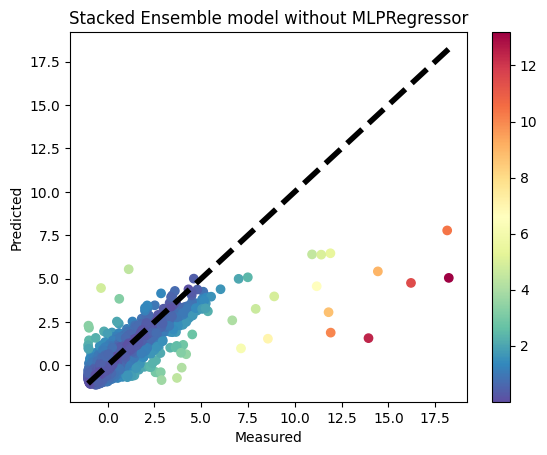

In [ ]:

# Split the data into train and test sets with random_state=42
X_train, X_test, y_train, y_test = train_test_split(X_gt_S, Y_gt_S, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

# Create polynomial features with degree=2
poly_features = PolynomialFeatures(degree=2)
X_train_poly = poly_features.fit_transform(X_train_std)
X_test_poly = poly_features.transform(X_test_std)

# Define the base models
base_models = [
    ("lasso", Lasso(alpha=0.01)),
    ("poly_ridge", Ridge(alpha=0.1)),
    ("adaboost", AdaBoostRegressor(RandomForestRegressor(n_estimators=40, max_features=4, max_depth=6), n_estimators=50))
]

# Create the stacked ensemble model
stacked_model = StackingRegressor(estimators=base_models, final_estimator=Ridge(alpha=1))

# Fit the stacked model
stacked_model.fit(X_train_std, y_train)

# Generate predictions for the test set
y_pred = stacked_model.predict(X_test_std)

# Calculate absolute difference between predicted and actual values
diff = np.abs(y_test - y_pred)

# Calculate MSE, MAE, and R2-score
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R2-score:", r2)

# Plot predicted vs. actual values with color variation based on prediction accuracy
fig, ax = plt.subplots()
scatter = ax.scatter(y_test, y_pred, c=diff, cmap='Spectral_r')
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.title("Stacked Ensemble model without MLPRegressor")
plt.colorbar(scatter)
plt.show()


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble

MSE: 0.28018929897191325
MAE: 0.2507974418708646
R2-score: 0.7362013405609418


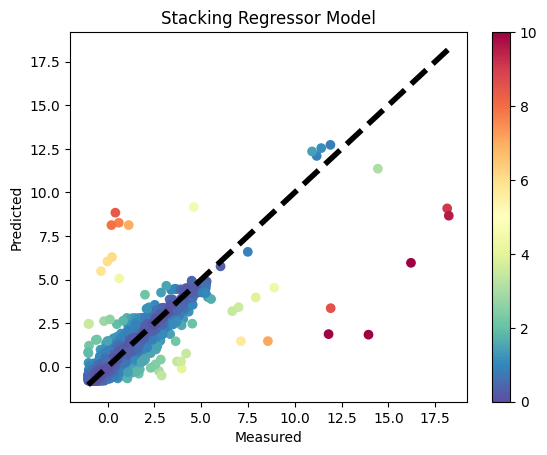

In [ ]:

# Base models
lasso = Lasso(alpha=0.01)
poly = make_pipeline(PolynomialFeatures(degree=2), Lasso(alpha=0.1))
mlp = MLPRegressor(hidden_layer_sizes=(30, 30, 60), activation='relu', alpha=10, max_iter=1000, random_state=42)
rf_adaboost = AdaBoostRegressor(base_estimator=RandomForestRegressor(n_estimators=50, max_features=4, max_depth=10, random_state=42), n_estimators=40, random_state=42)

# Meta model
meta_model = RandomForestRegressor(n_estimators=50, max_features=4, max_depth=6, random_state=42)

# Stacking Regressor
stacking_regressor = StackingRegressor(
    estimators=[
        ('lasso', lasso),
        ('poly', poly),
        ('mlp', mlp),
        ('rf_adaboost', rf_adaboost)
    ],
    final_estimator=meta_model,
    cv=10
)

# Train the stacking model
stacking_regressor.fit(X_train, y_train)

# Make predictions
y_pred = stacking_regressor.predict(X_test)
# Calculate absolute difference between predicted and actual values
diff = np.abs(y_test - y_pred)
# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MSE:", mse)
print("MAE:", mae)
print("R2-score:", r2)
# Plot predicted vs. actual values with color variation based on prediction accuracy
fig, ax = plt.subplots()
scatter = ax.scatter(y_test, y_pred, c=diff, cmap='Spectral_r', vmin=0, vmax=10)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.title("Stacking Regressor Model")
plt.colorbar(scatter)
plt.show()